## Chargement et Exploration des Données

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import os

# Charger les fichiers CSV
general_data = pd.read_csv("datasets/raw/general_data.csv")
manager_survey = pd.read_csv("datasets/raw/manager_survey_data.csv")
employee_survey = pd.read_csv("datasets/raw/employee_survey_data.csv")

# Extraire et charger les fichiers ZIP contenant les horaires de travail
with zipfile.ZipFile("datasets/in_out_time.zip", "r") as zip_ref:
    zip_ref.extractall("datasets/in_out_time")

# Charger les fichiers horaires
in_time = pd.read_csv("datasets/in_out_time/in_time.csv")
out_time = pd.read_csv("datasets/in_out_time/out_time.csv")


In [2]:
#faire une copie du dataset general_data afin d'éviter tout soucis
general_data_copy = general_data.copy()


In [3]:
#  employee_survey_data et manager_survey_data sont joints via la colonne "EmployeeID"
general_data_copy = general_data_copy.join(employee_survey.set_index("EmployeeID"), on="EmployeeID")
general_data_copy = general_data_copy.join(manager_survey.set_index("EmployeeID"), on="EmployeeID")


In [4]:
# Aperçu des datasets
print(general_data_copy.head())

   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   TotalWorkingYears TrainingTimesLastYear YearsAtCompany  \
0                1.0     

In [5]:
# Vérifier les types de données et les valeurs nulles
print(general_data_copy.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [6]:
# Vérifier les valeurs uniques des colonnes catégoriques
print(general_data_copy.nunique())

Age                          43
Attrition                     2
BusinessTravel                3
Department                    3
DistanceFromHome             29
Education                     5
EducationField                6
EmployeeCount                 1
EmployeeID                 4410
Gender                        2
JobLevel                      5
JobRole                       9
MaritalStatus                 3
MonthlyIncome              1349
NumCompaniesWorked           10
Over18                        1
PercentSalaryHike            15
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWithCurrManager         18
EnvironmentSatisfaction       4
JobSatisfaction               4
WorkLifeBalance               4
JobInvolvement                4
PerformanceRating             2
dtype: int64


## Nettoyage des Données

In [7]:

# Drop columns where all values are NaN and replace NaN with 0
in_time = in_time.dropna(axis=1, how='all').replace(0, np.nan)
out_time = out_time.dropna(axis=1, how='all').replace(0, np.nan)

# Convert to datetime while handling missing values
for col in in_time.columns[1:]:
    in_time[col] = pd.to_datetime(in_time[col], errors='coerce')

for col in out_time.columns[1:]:
    out_time[col] = pd.to_datetime(out_time[col], errors='coerce')

# Convert to Unix timestamp (seconds)
for col in in_time.columns[1:]:
    in_time[col] = in_time[col].astype('int64') // 10**9

for col in out_time.columns[1:]:
    out_time[col] = out_time[col].astype('int64') // 10**9


in_time = in_time.sort_values(by="Unnamed: 0", ascending=True)
out_time = out_time.sort_values(by="Unnamed: 0", ascending=True)


then we need to calculate the working time per day for each employee and to do so we need to subtract in_time and out_time.

The dataset contains an identifier column, which holds the unique Employee IDs. When performing the subtraction (out_time - in_time), Pandas aligns columns based on their names. If the Employee ID column is not handled properly, it may be affected by the subtraction.

To ensure the Employee ID remains intact, we apply the following transformation before subtraction:

In [8]:
out_time["Unnamed: 0"] = out_time["Unnamed: 0"] + out_time["Unnamed: 0"]
time = out_time.subtract(in_time, axis=1)

Once the daily time calculation is completed, we perform another subtraction, this time between the daily time worked by the employee and the daily working hours stated in their contract.

Next, negative values (lateness time) are replaced with -1, and positive values (overtime hours) are replaced with 1.

Finally, these values are summed to obtain an annual attendance score for each employee. These values will be stored in a column called AttendanceScore.

In [9]:
time_tmp = time.copy()
time_tmp = time_tmp.join(general_data.set_index("EmployeeID"), on="Unnamed: 0")
time_tmp["EmployeeID"] = time_tmp["Unnamed: 0"]
time_tmp["StandardHours"] = time_tmp["StandardHours"] * 3600
time_tmp["AttendanceScore"] = 0

for date in time_tmp.keys()[1:len(time.keys()[1:]) +1]:        
    time_tmp[date] = time_tmp[date] - time_tmp["StandardHours"]
    time_tmp[date] = time_tmp[date].where(time_tmp[date] > 0, -1)
    time_tmp[date] = time_tmp[date].where(time_tmp[date] < 0, 1)
    time_tmp["AttendanceScore"] = time_tmp["AttendanceScore"] + time_tmp[date]

In [10]:
# add the new column to the general data copy
general_data_copy = pd.merge(general_data_copy,time_tmp[['EmployeeID', 'AttendanceScore']],on='EmployeeID', how='left')
print(general_data_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [11]:
# supression des donnés 
general_data_copy.drop(['EmployeeID'], axis=1, inplace=True)
general_data_copy.drop(['Over18'], axis=1, inplace=True)
general_data_copy.drop(['EmployeeCount'], axis=1, inplace=True)
general_data_copy.drop(['StandardHours'], axis=1, inplace=True)
general_data_copy.drop(['Gender'], axis=1, inplace=True)
general_data_copy.drop(['StockOptionLevel'], axis=1, inplace=True)
general_data_copy.drop(['Age'], axis=1, inplace=True)



In [12]:
# Compter les valeurs nulles
print(general_data_copy.isnull().sum())


Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
PercentSalaryHike           0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
AttendanceScore             0
dtype: int64


In [13]:
# Remplacer les valeurs manquantes par la médiane
incomplete_variables = ["JobSatisfaction","EnvironmentSatisfaction","WorkLifeBalance", "NumCompaniesWorked","TotalWorkingYears"]
for variable in incomplete_variables:
	median = general_data_copy[variable].median()
	general_data_copy[variable].fillna(median, inplace=True)

print(general_data_copy.isnull().sum())

Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
AttendanceScore            0
dtype: int64


In [14]:
general_data_copy.describe(include="all")


,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MaritalStatus,MonthlyIncome,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore
count,4410,4410,4410,4410.000000,4410.000000,4410,4410.000000,4410,4410,4410.000000,...,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
unique,2,3,3,NaN,NaN,6,NaN,9,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,No,Travel_Rarely,Research & Development,NaN,NaN,Life Sciences,NaN,Sales Executive,Married,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3699,3129,2883,NaN,NaN,1818,NaN,978,2019,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.192517,2.912925,NaN,2.063946,NaN,NaN,65029.312925,...,2.799320,7.008163,2.187755,4.123129,2.725170,2.729478,2.763492,2.729932,3.153741,-96.693878
std,NaN,NaN,NaN,8.105026,1.023933,NaN,1.106689,NaN,NaN,47068.888559,...,1.288978,6.125135,3.221699,3.567327,1.089852,1.098904,0.703541,0.711400,0.360742,200.040122
min,NaN,NaN,NaN,1.000000,1.000000,NaN,1.000000,NaN,NaN,10090.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,-249.000000
25%,NaN,NaN,NaN,2.000000,2.000000,NaN,1.000000,NaN,NaN,29110.000000,...,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,-249.000000
50%,NaN,NaN,NaN,7.000000,3.000000,NaN,2.000000,NaN,NaN,49190.000000,...,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,-237.000000
75%,NaN,NaN,NaN,14.000000,4.000000,NaN,3.000000,NaN,NaN,83800.000000,...,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,161.000000


In [15]:
# We will modify the following data to have results that are easier to analyze

general_data_copy['PerformanceRating'] = general_data_copy['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'})
general_data_copy['EnvironmentSatisfaction'] = general_data_copy['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
general_data_copy['JobSatisfaction'] = general_data_copy['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
general_data_copy['JobInvolvement'] = general_data_copy['JobInvolvement'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
general_data_copy['WorkLifeBalance'] = general_data_copy['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'})
general_data_copy['Education'] = general_data_copy['Education'].replace({ 1 : 'Below College', 2: 'College',3: 'Bachelor',4: 'Master',5 : 'Doctor'})
general_data_copy['JobLevel'] = general_data_copy["JobLevel"].replace({ 1 : 'Apprentice', 2: 'Junior Employee',3: 'Employee',4: 'Manager',5 : 'Director'})

In [16]:
general_data_copy.head(10)

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MaritalStatus,MonthlyIncome,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore
0,No,Travel_Rarely,Sales,6,College,Life Sciences,Apprentice,Healthcare Representative,Married,131160,...,6,1,0,0,High,Very High,Good,High,Excellent,-249
1,Yes,Travel_Frequently,Research & Development,10,Below College,Life Sciences,Apprentice,Research Scientist,Single,41890,...,3,5,1,4,High,Medium,Best,Medium,Outstanding,-165
2,No,Travel_Frequently,Research & Development,17,Master,Other,Manager,Sales Executive,Married,193280,...,2,5,0,3,Medium,Medium,Bad,High,Excellent,-249
3,No,Non-Travel,Research & Development,2,Doctor,Life Sciences,Employee,Human Resources,Married,83210,...,5,8,7,5,Very High,Very High,Better,Medium,Excellent,-249
4,No,Travel_Rarely,Research & Development,10,Below College,Medical,Apprentice,Sales Executive,Single,23420,...,2,6,0,4,Very High,Low,Better,High,Excellent,-19
5,No,Travel_Rarely,Research & Development,8,Bachelor,Life Sciences,Manager,Research Director,Married,40710,...,5,7,7,7,High,Medium,Good,High,Excellent,225
6,Yes,Travel_Rarely,Research & Development,11,College,Medical,Junior Employee,Sales Executive,Single,58130,...,2,0,0,0,Low,High,Bad,High,Outstanding,-247
7,No,Travel_Rarely,Research & Development,18,Bachelor,Life Sciences,Junior Employee,Sales Executive,Married,31430,...,2,0,0,0,Low,Medium,Better,High,Outstanding,-249
8,No,Travel_Rarely,Research & Development,1,Bachelor,Life Sciences,Employee,Laboratory Technician,Married,20440,...,2,9,7,8,Medium,Very High,Better,High,Outstanding,-247
9,No,Non-Travel,Research & Development,7,Master,Medical,Manager,Laboratory Technician,Divorced,134640,...,2,6,1,5,Medium,Low,Better,High,Excellent,-249


array([[<Axes: title={'center': 'DistanceFromHome'}>,
        <Axes: title={'center': 'MonthlyIncome'}>,
        <Axes: title={'center': 'NumCompaniesWorked'}>],
       [<Axes: title={'center': 'PercentSalaryHike'}>,
        <Axes: title={'center': 'TotalWorkingYears'}>,
        <Axes: title={'center': 'TrainingTimesLastYear'}>],
       [<Axes: title={'center': 'YearsAtCompany'}>,
        <Axes: title={'center': 'YearsSinceLastPromotion'}>,
        <Axes: title={'center': 'YearsWithCurrManager'}>],
       [<Axes: title={'center': 'AttendanceScore'}>, <Axes: >, <Axes: >]],
      dtype=object)

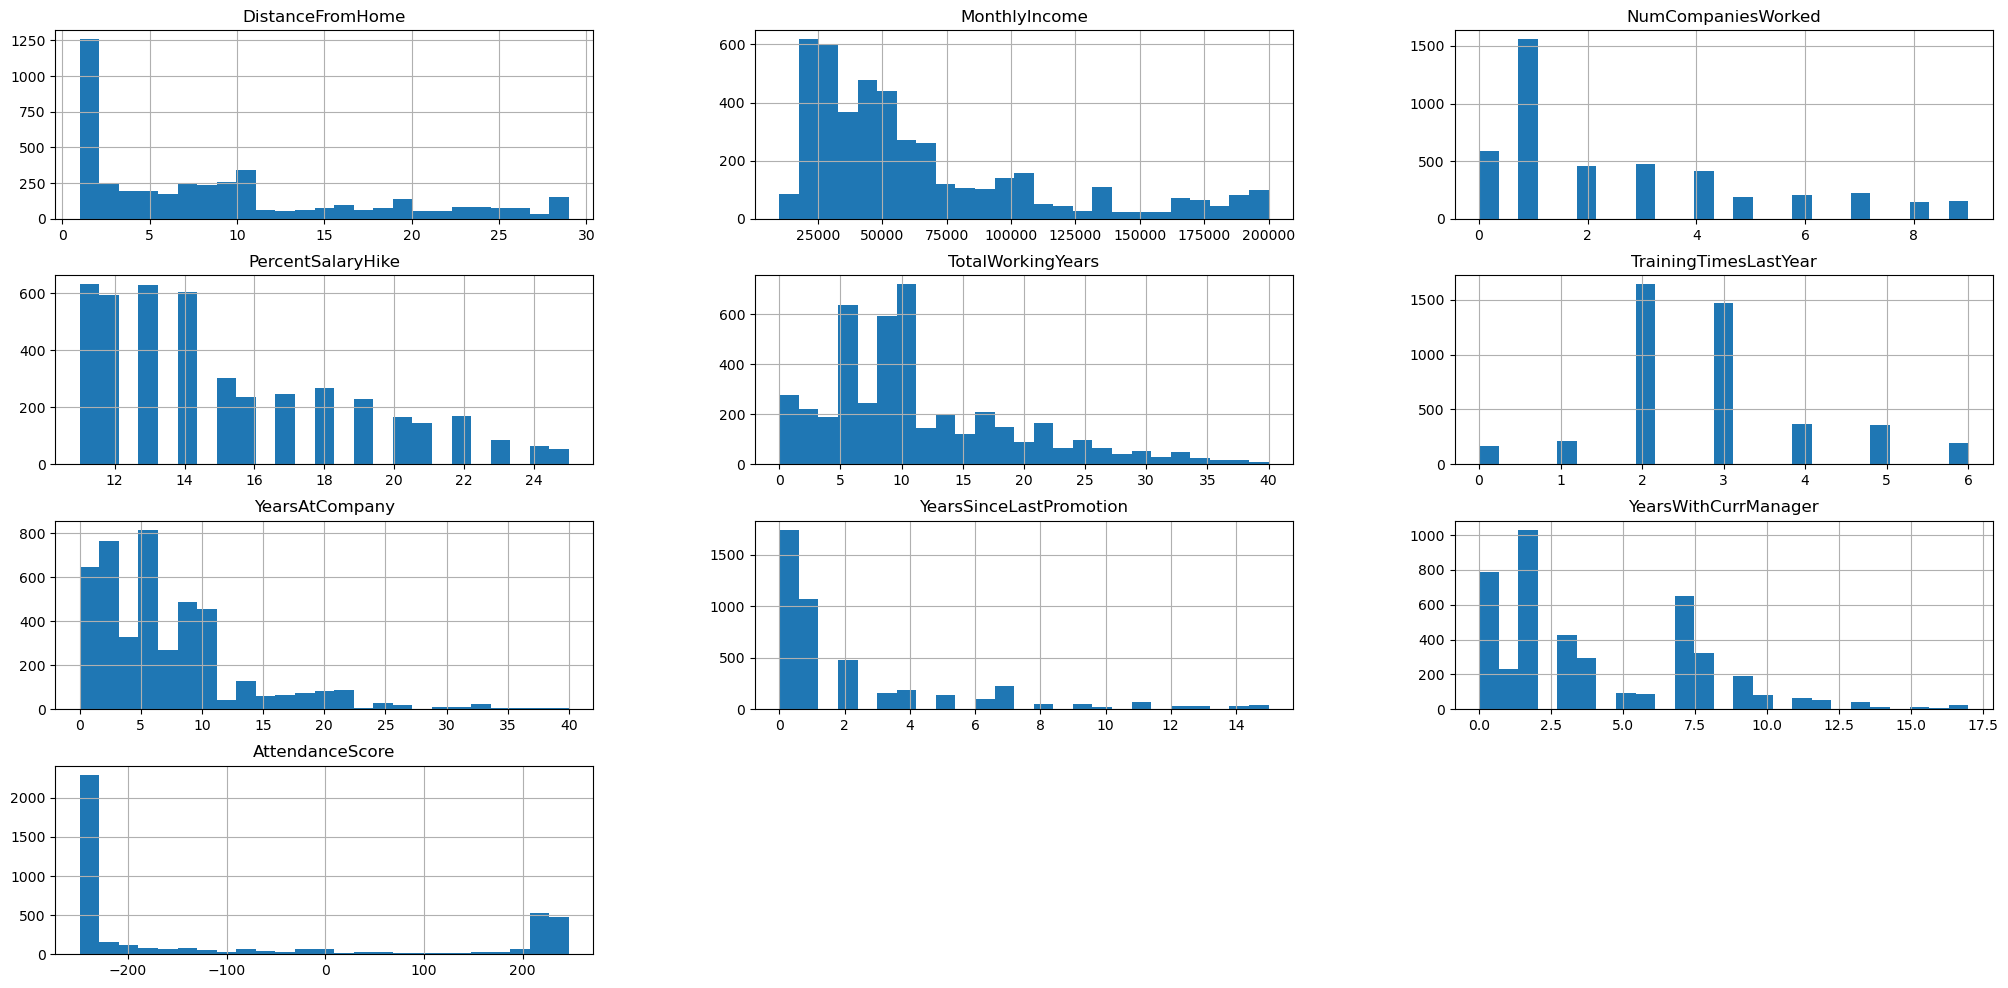

In [17]:
general_data_copy.hist(figsize=(25,12), bins=25,column=list(general_data_copy.columns))


Below you will find all the graphs with the object type variables of the dataset:

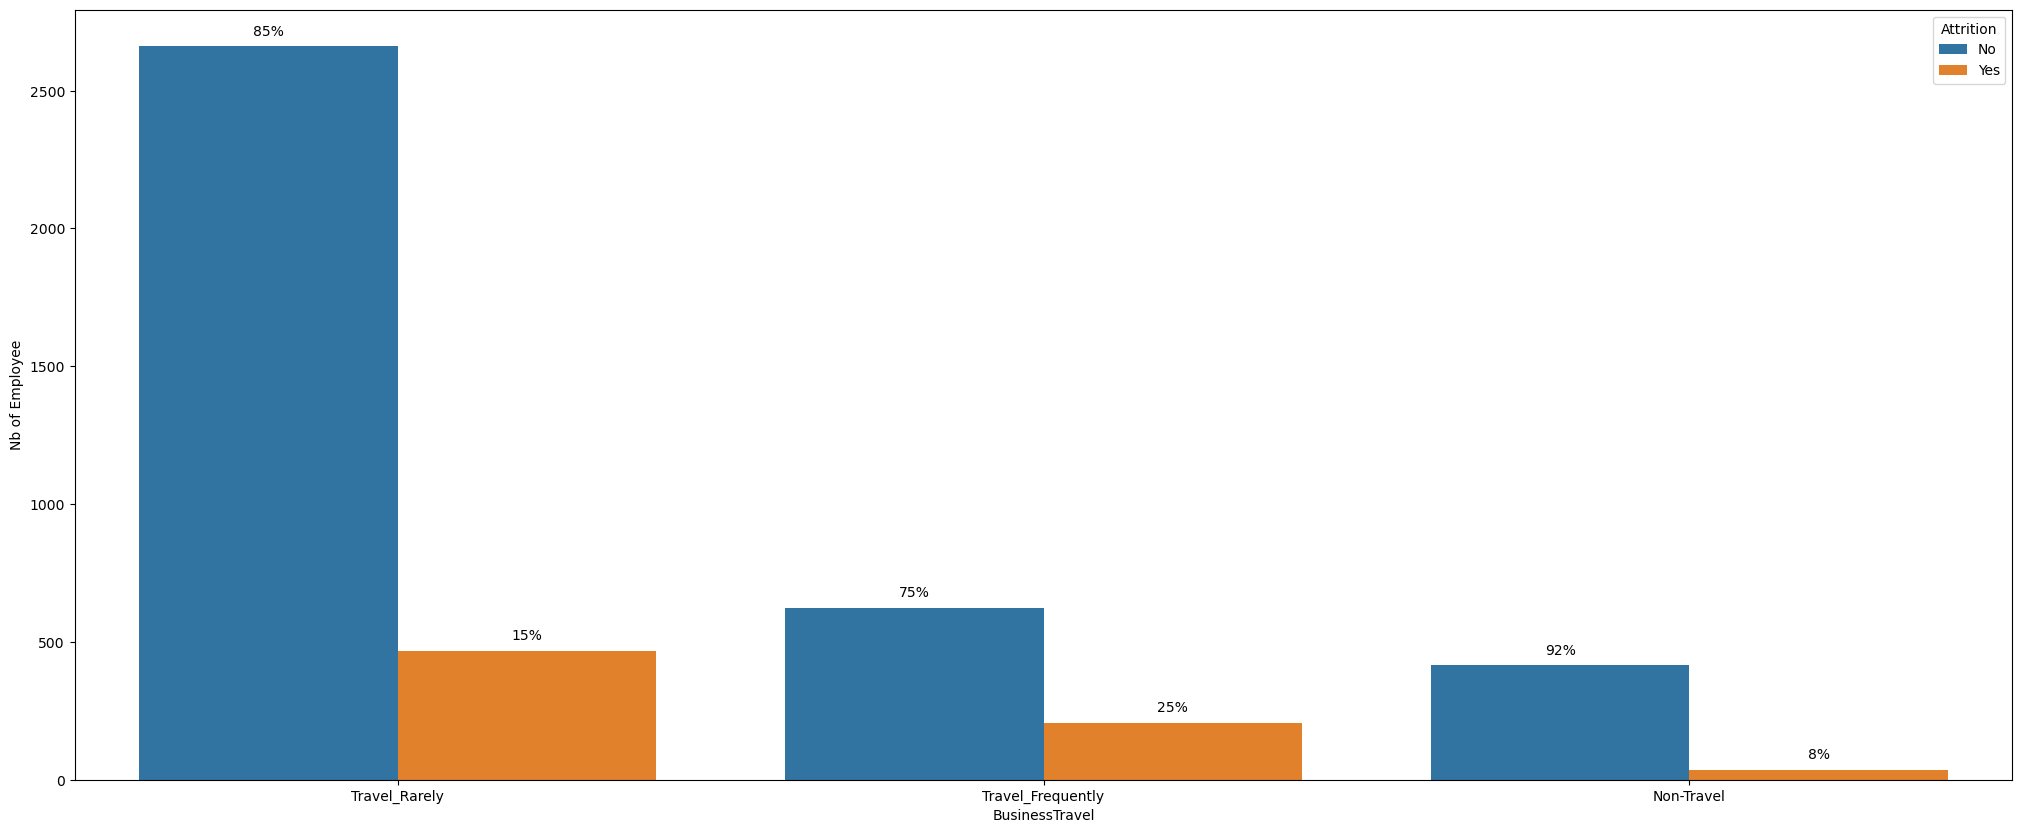

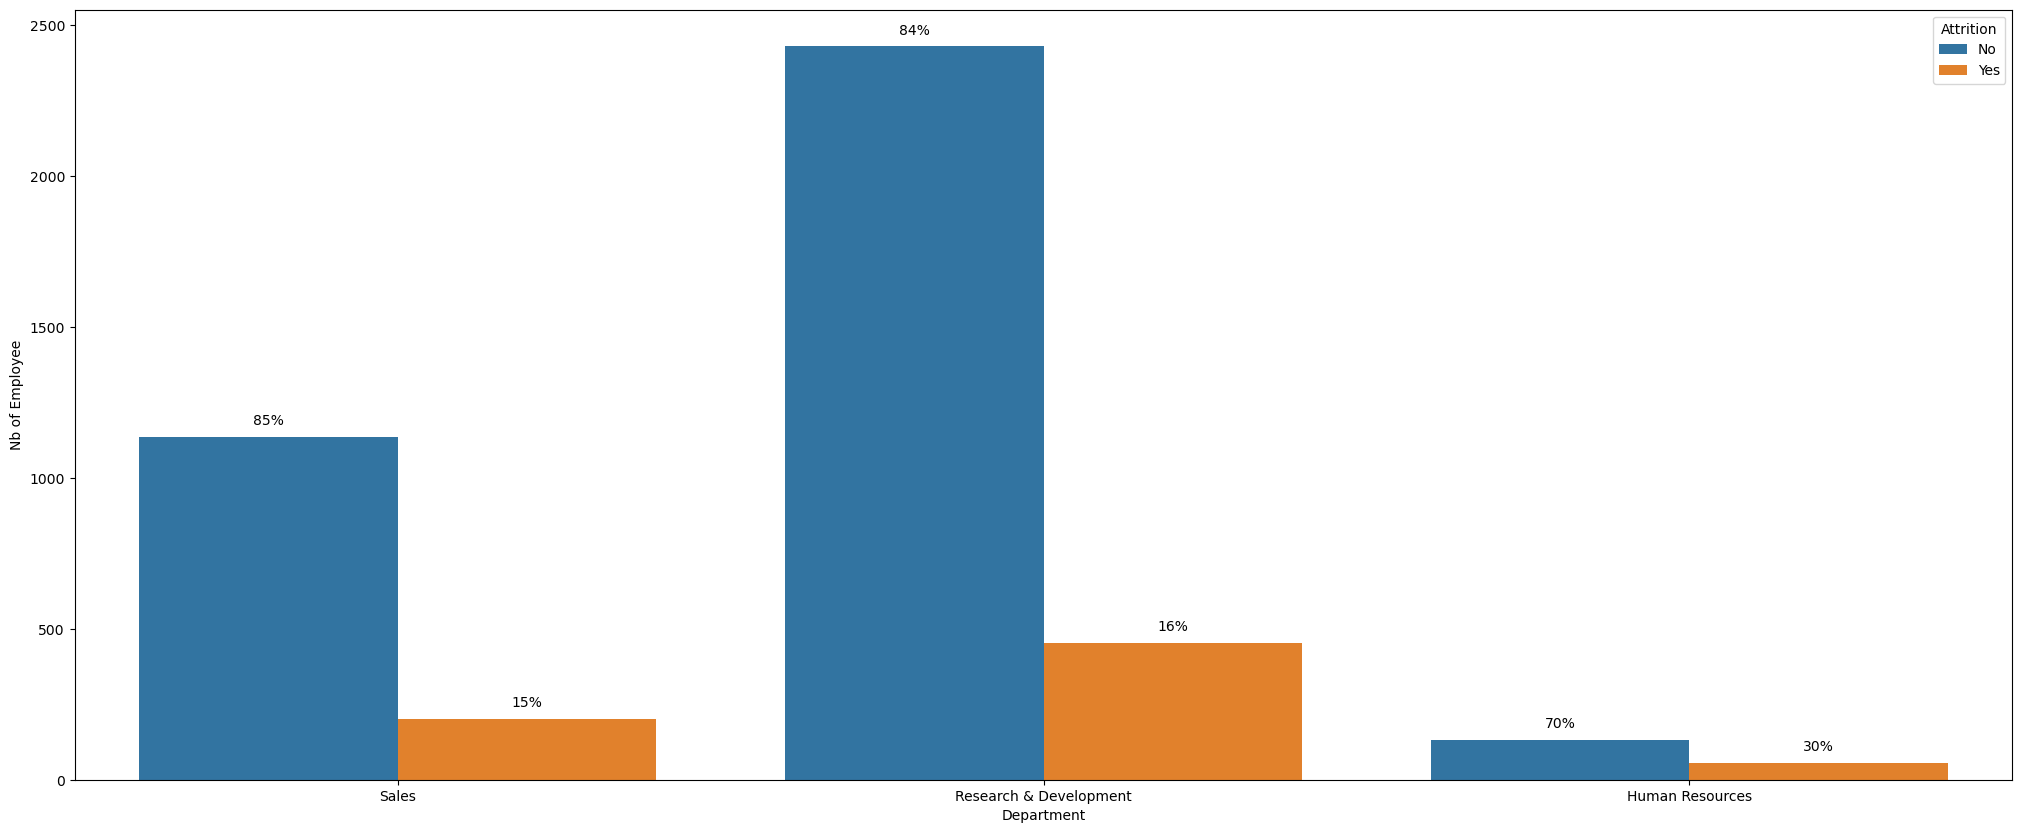

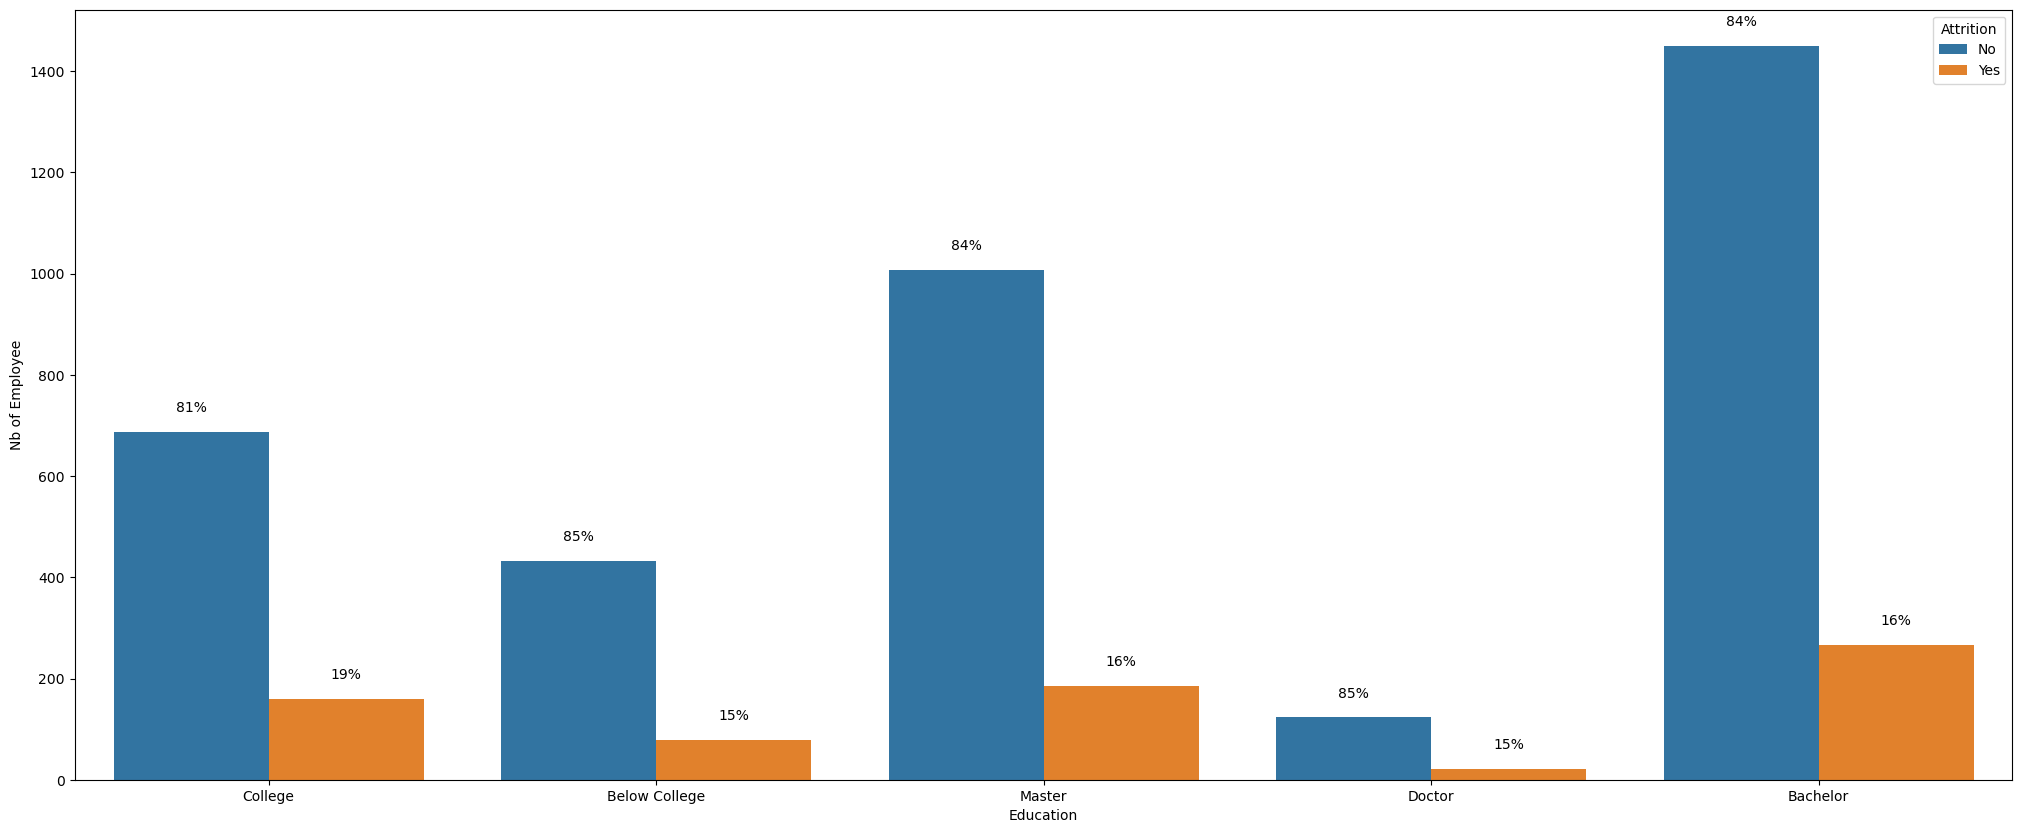

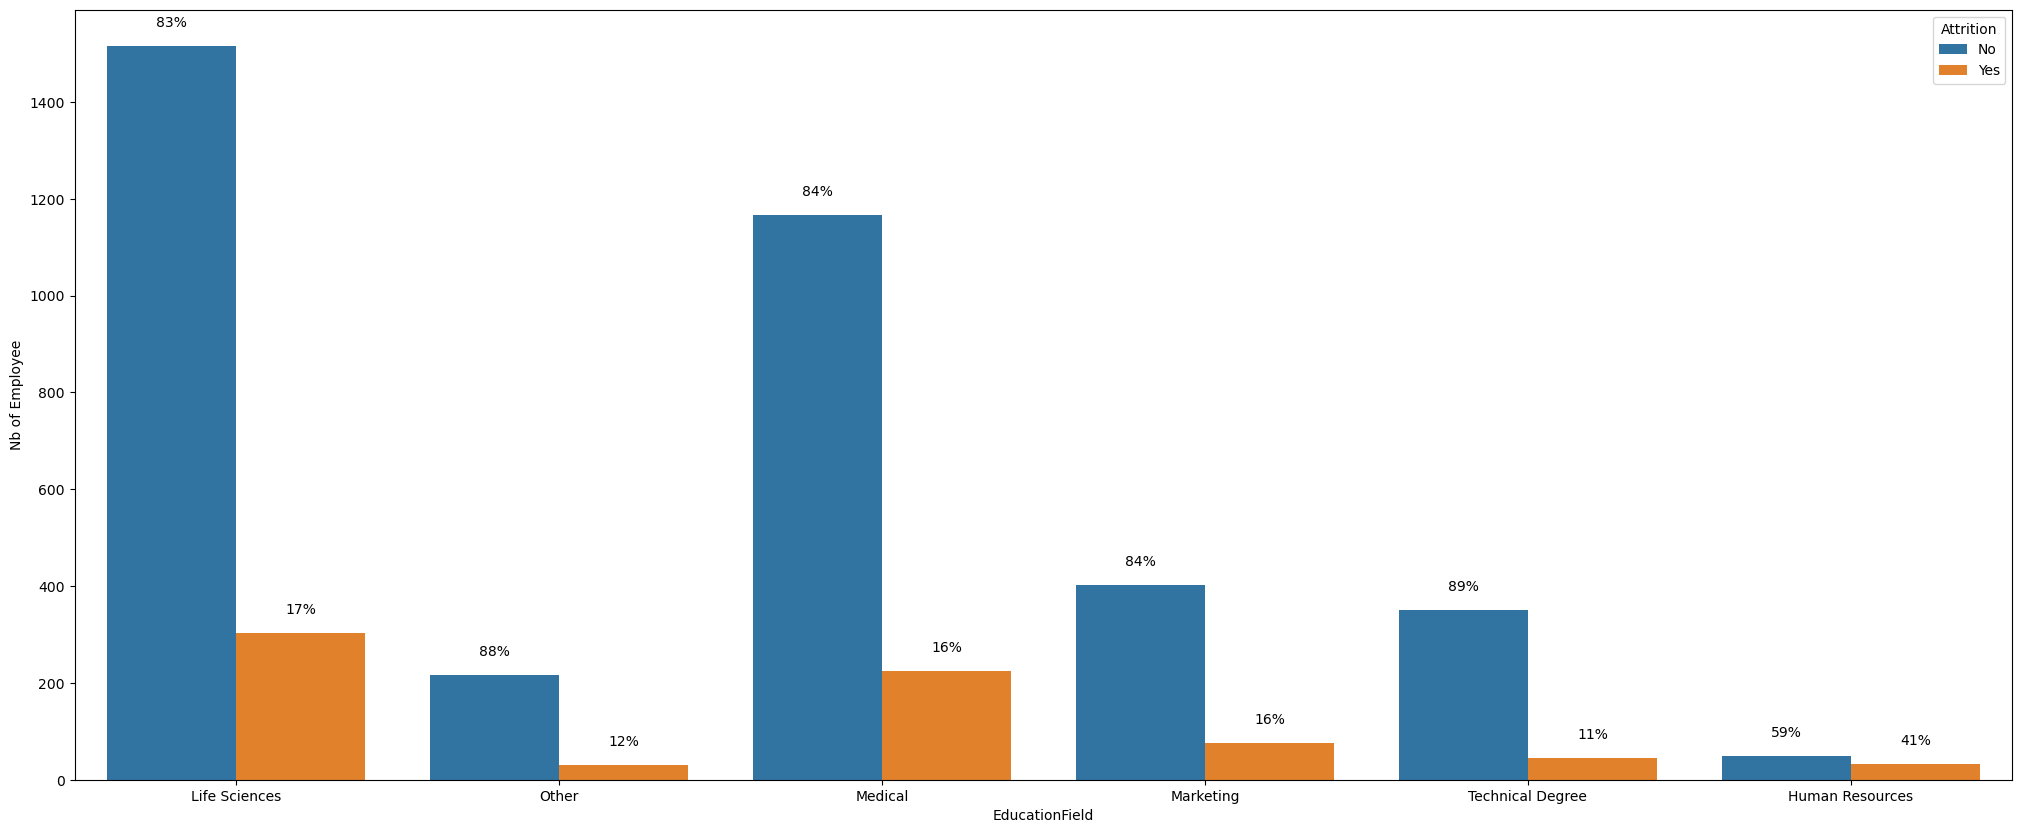

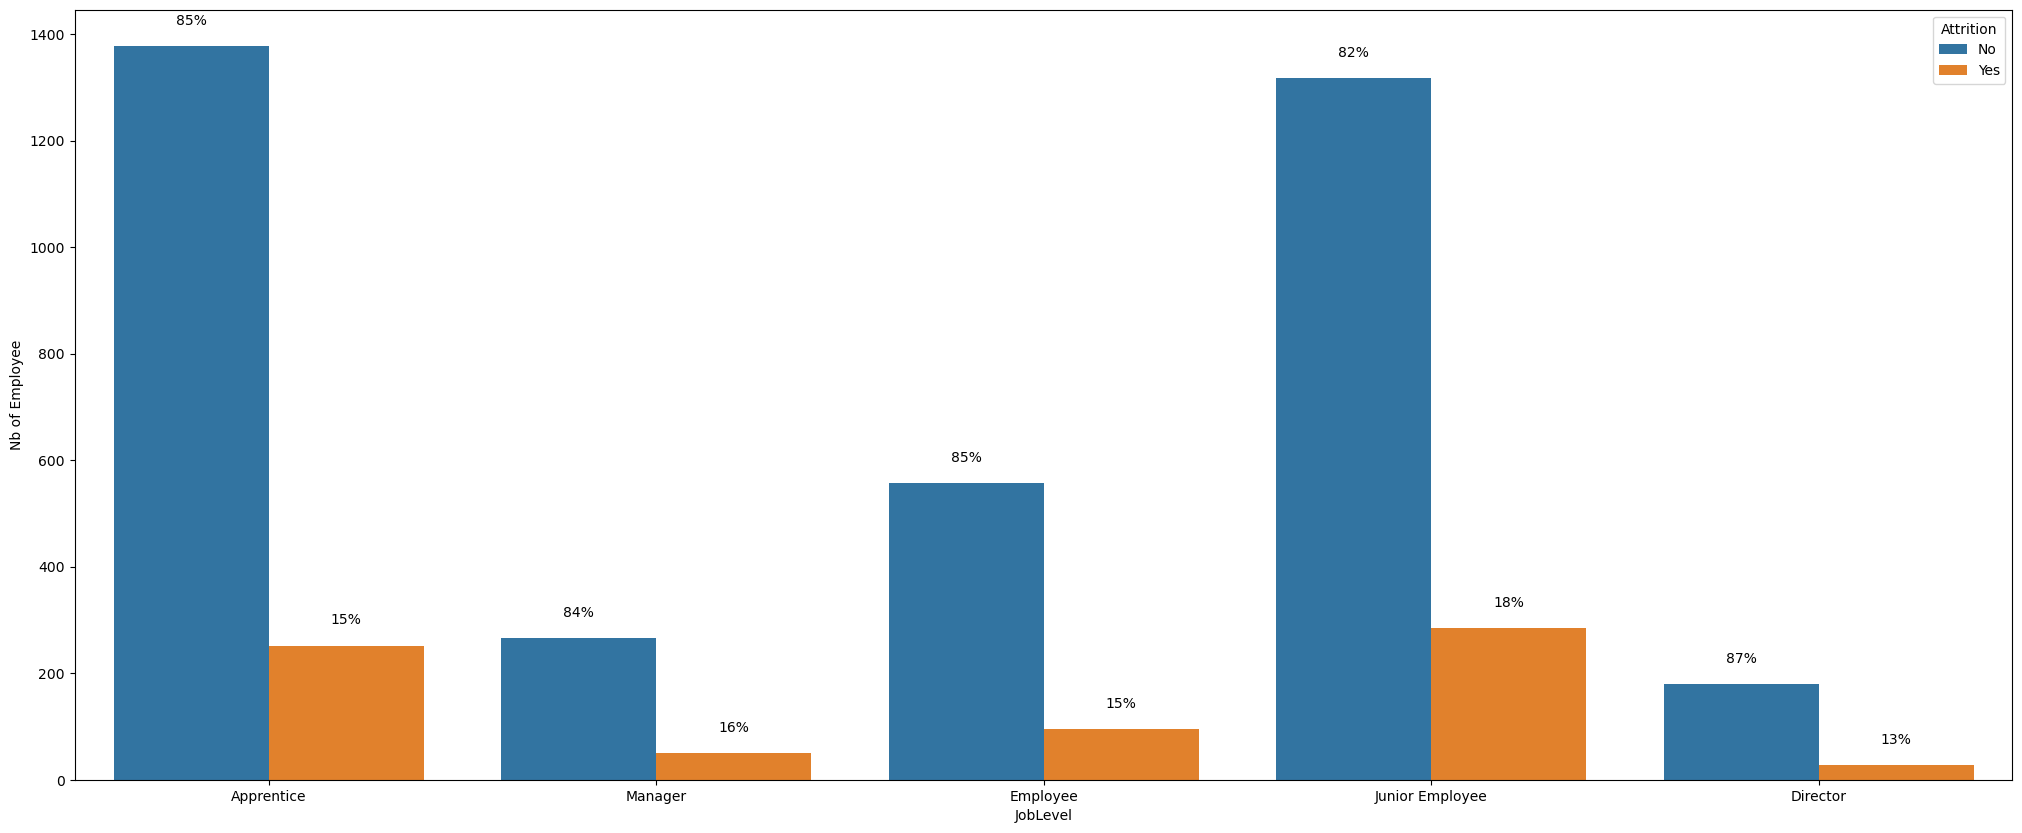

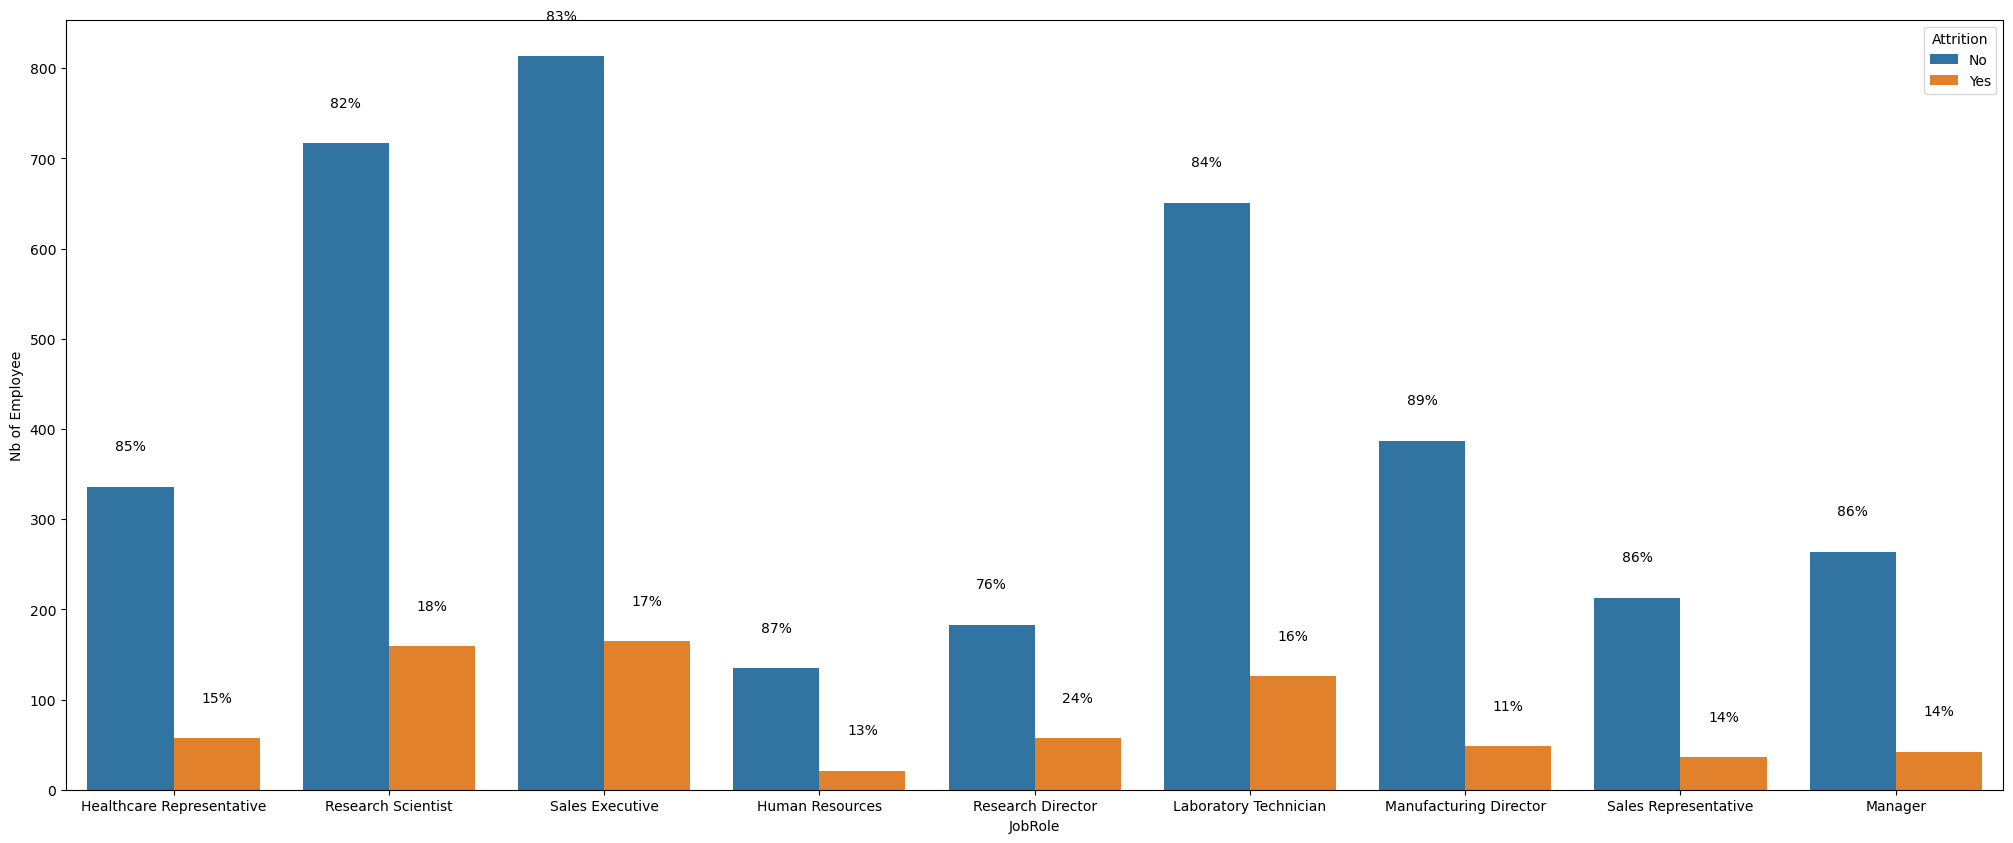

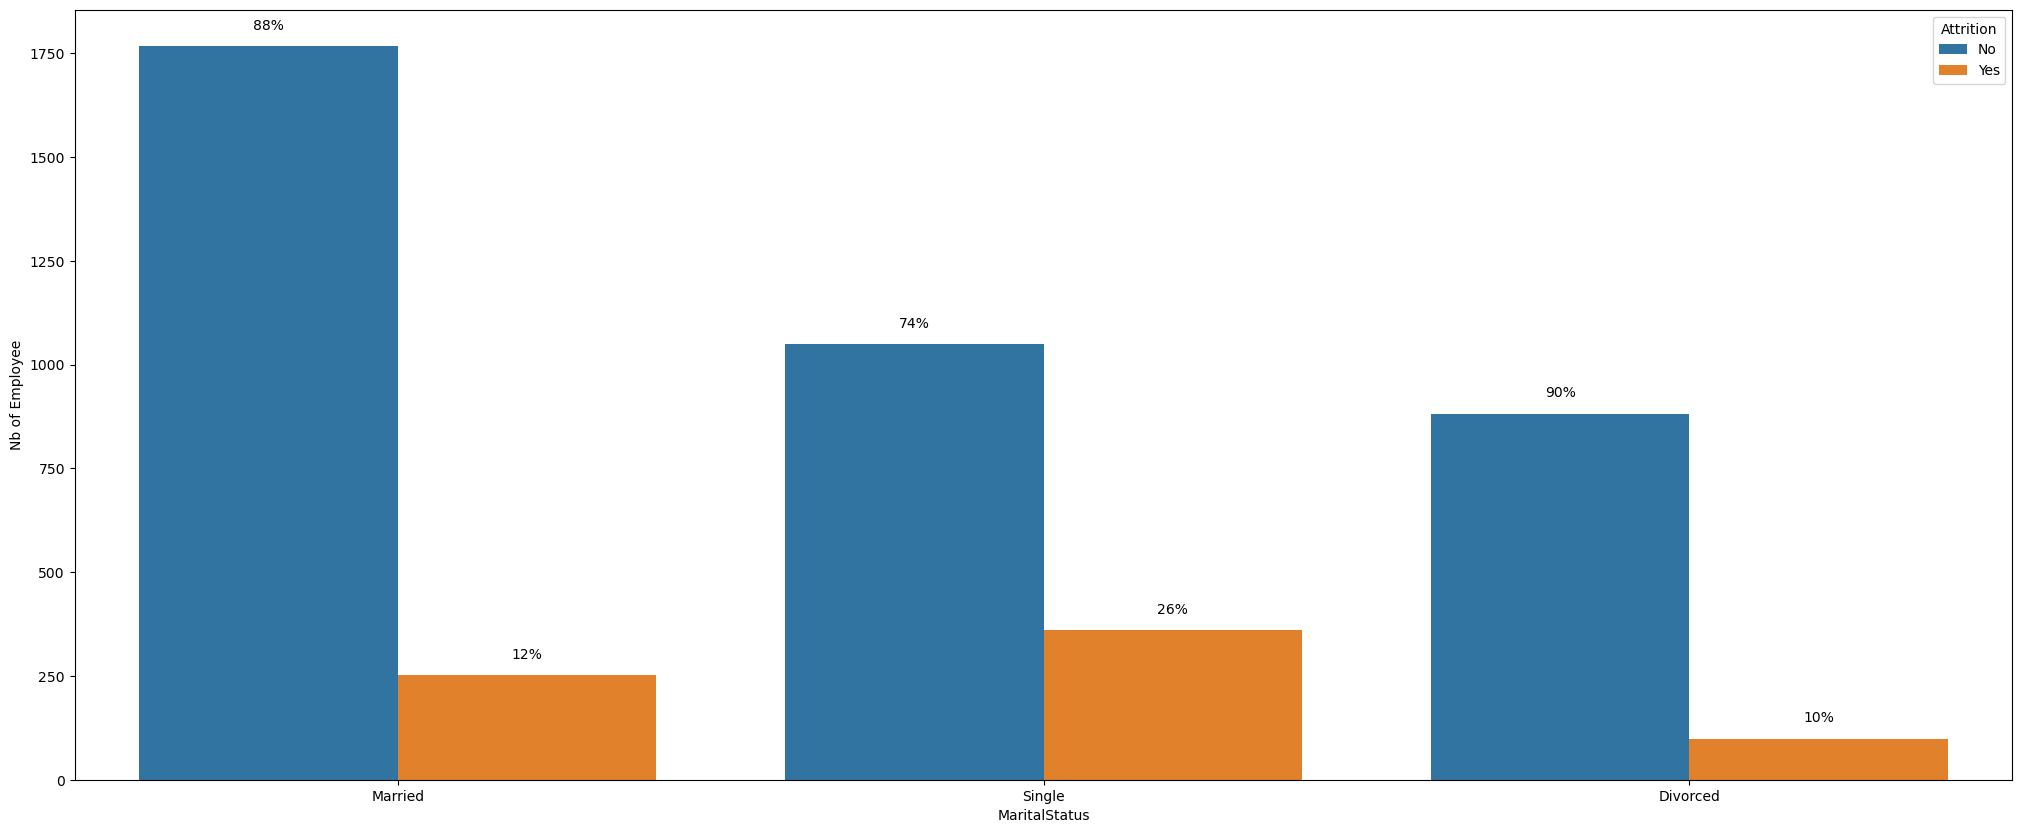

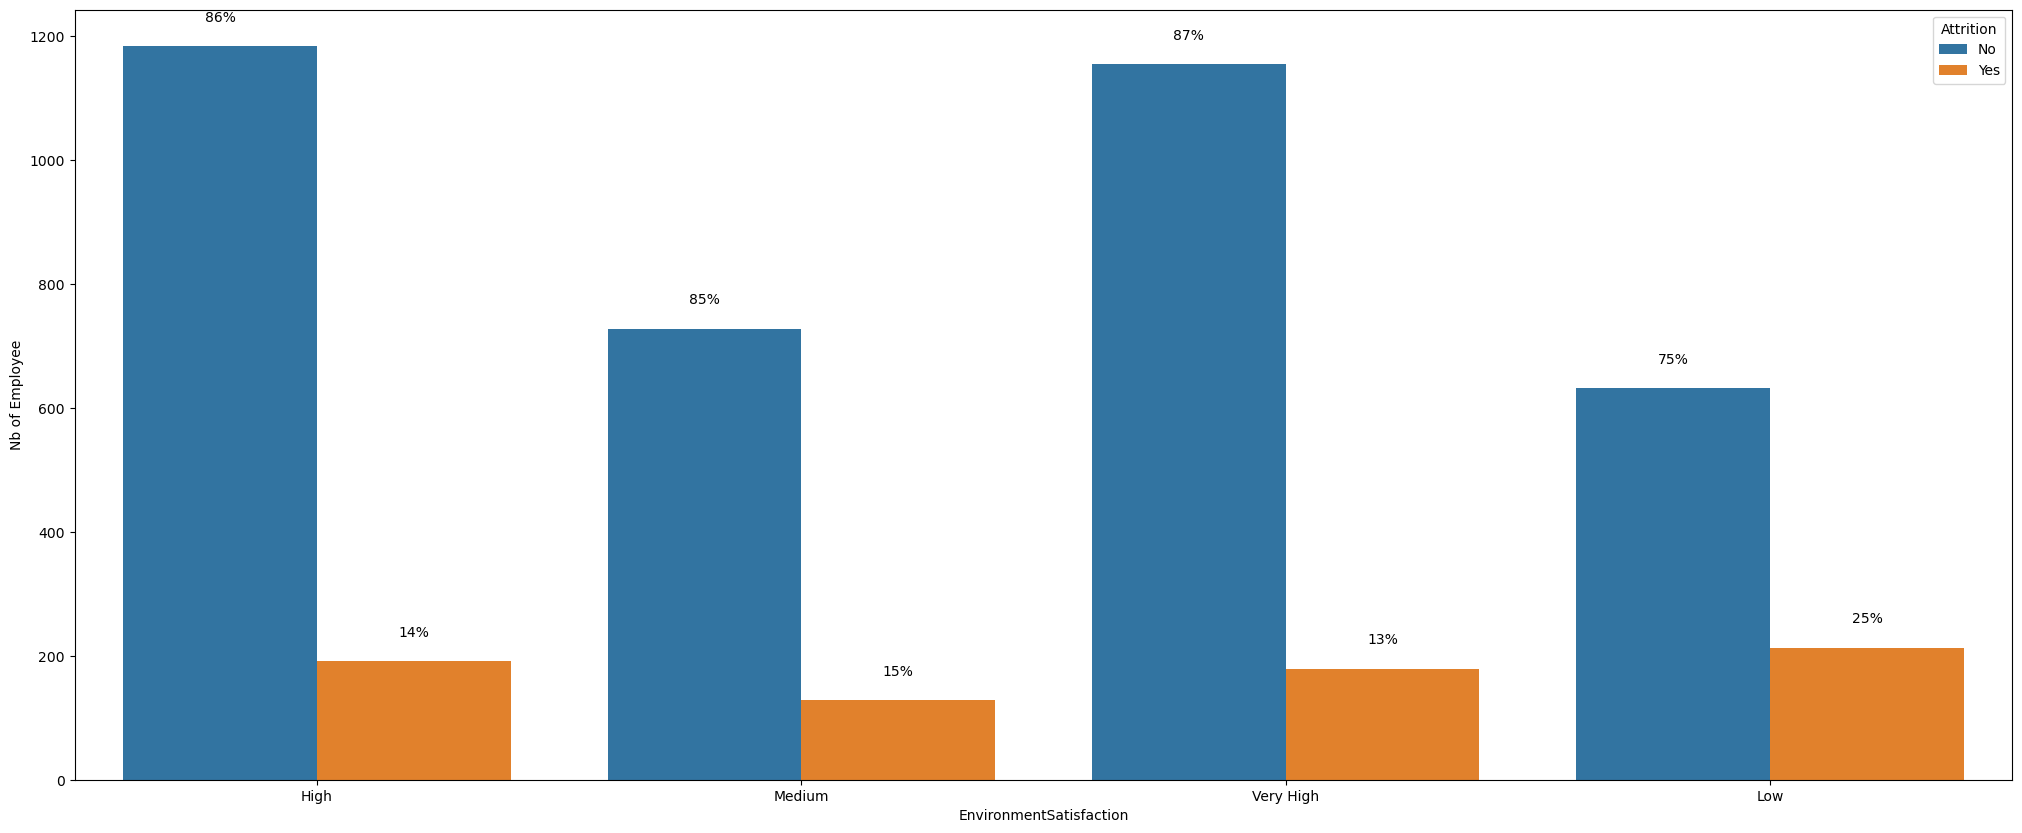

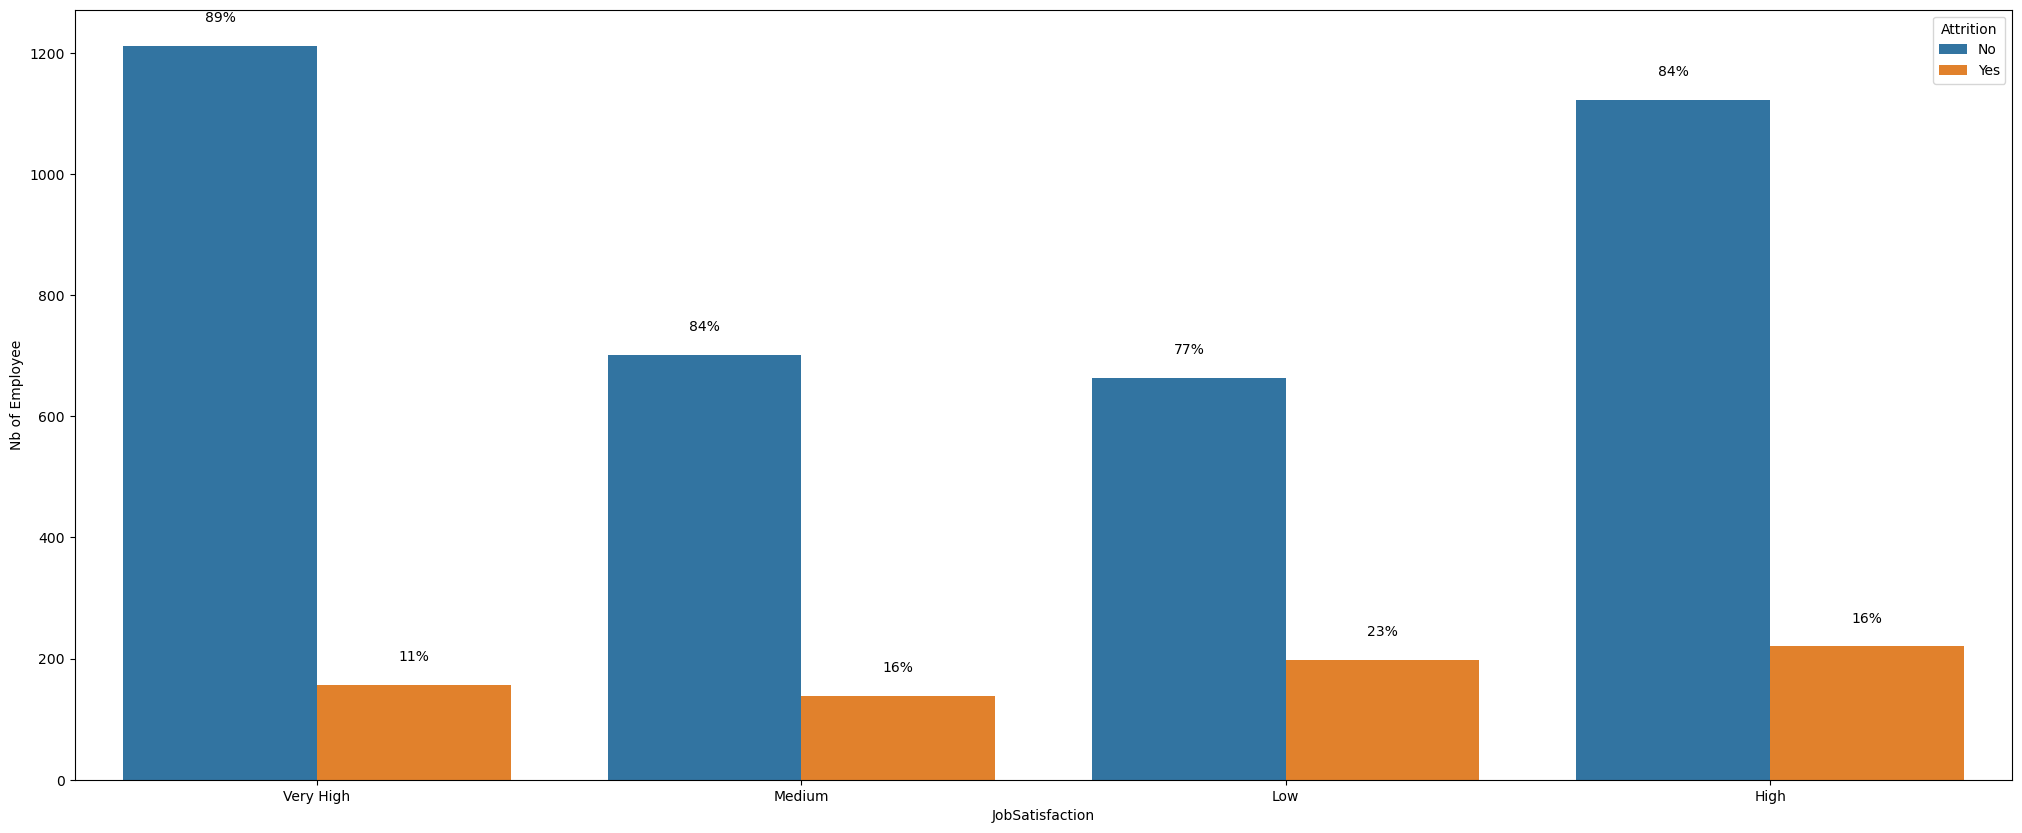

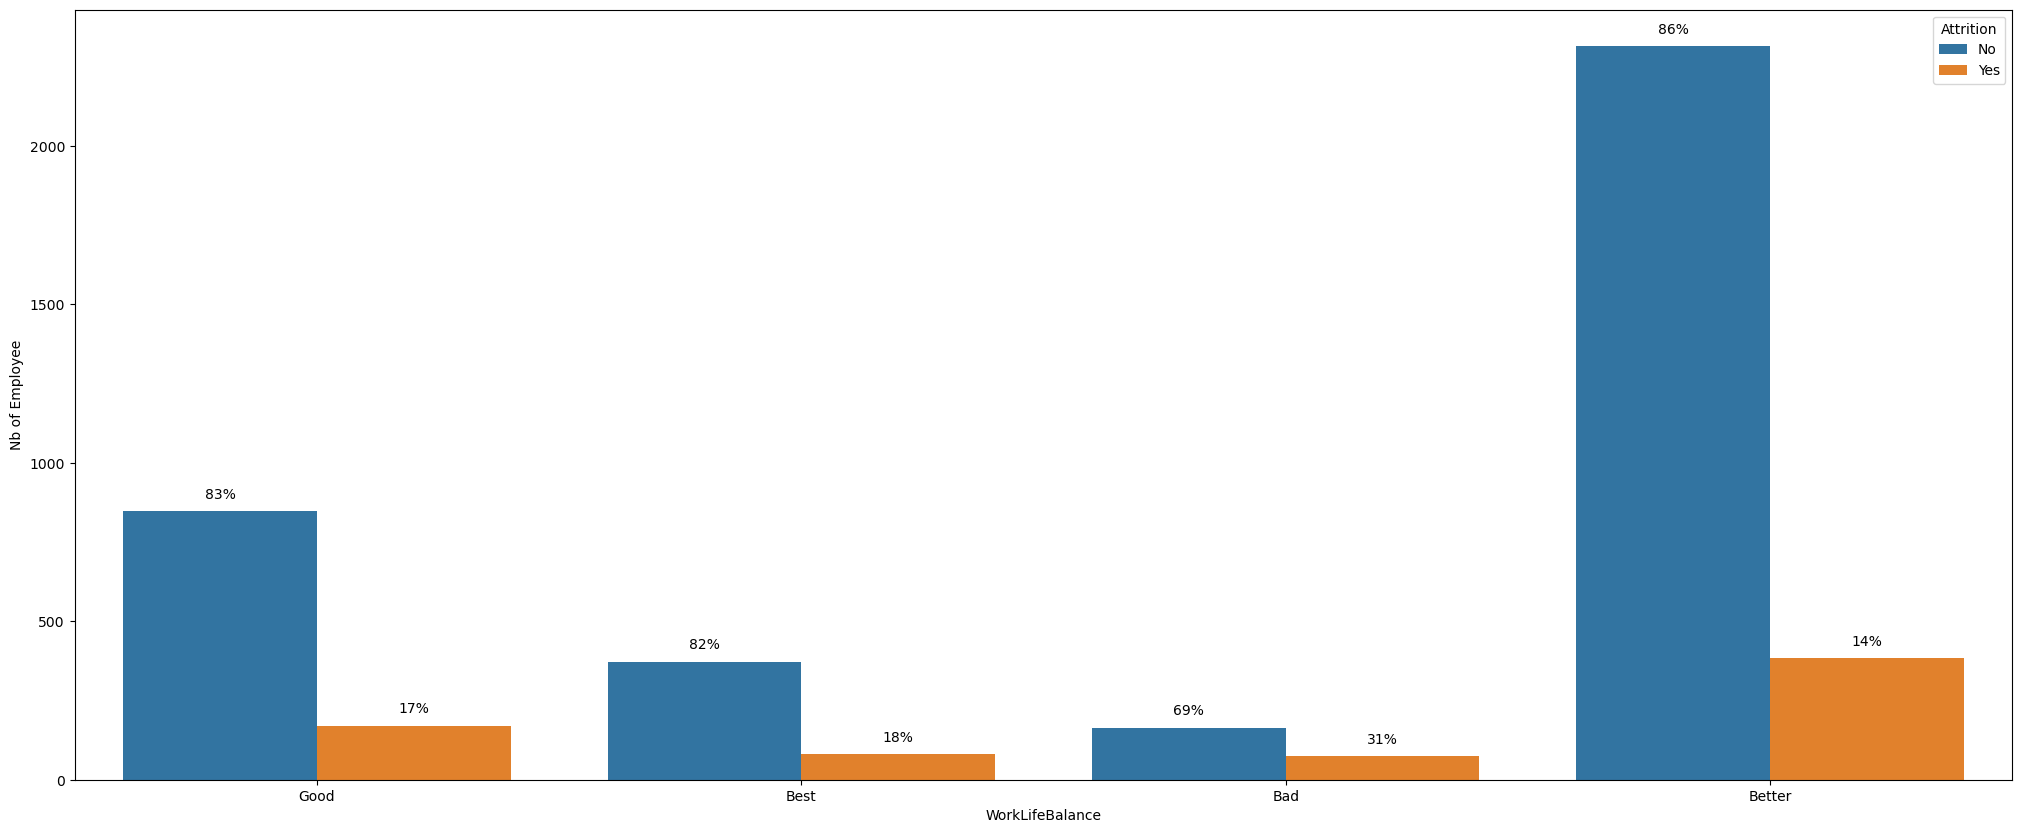

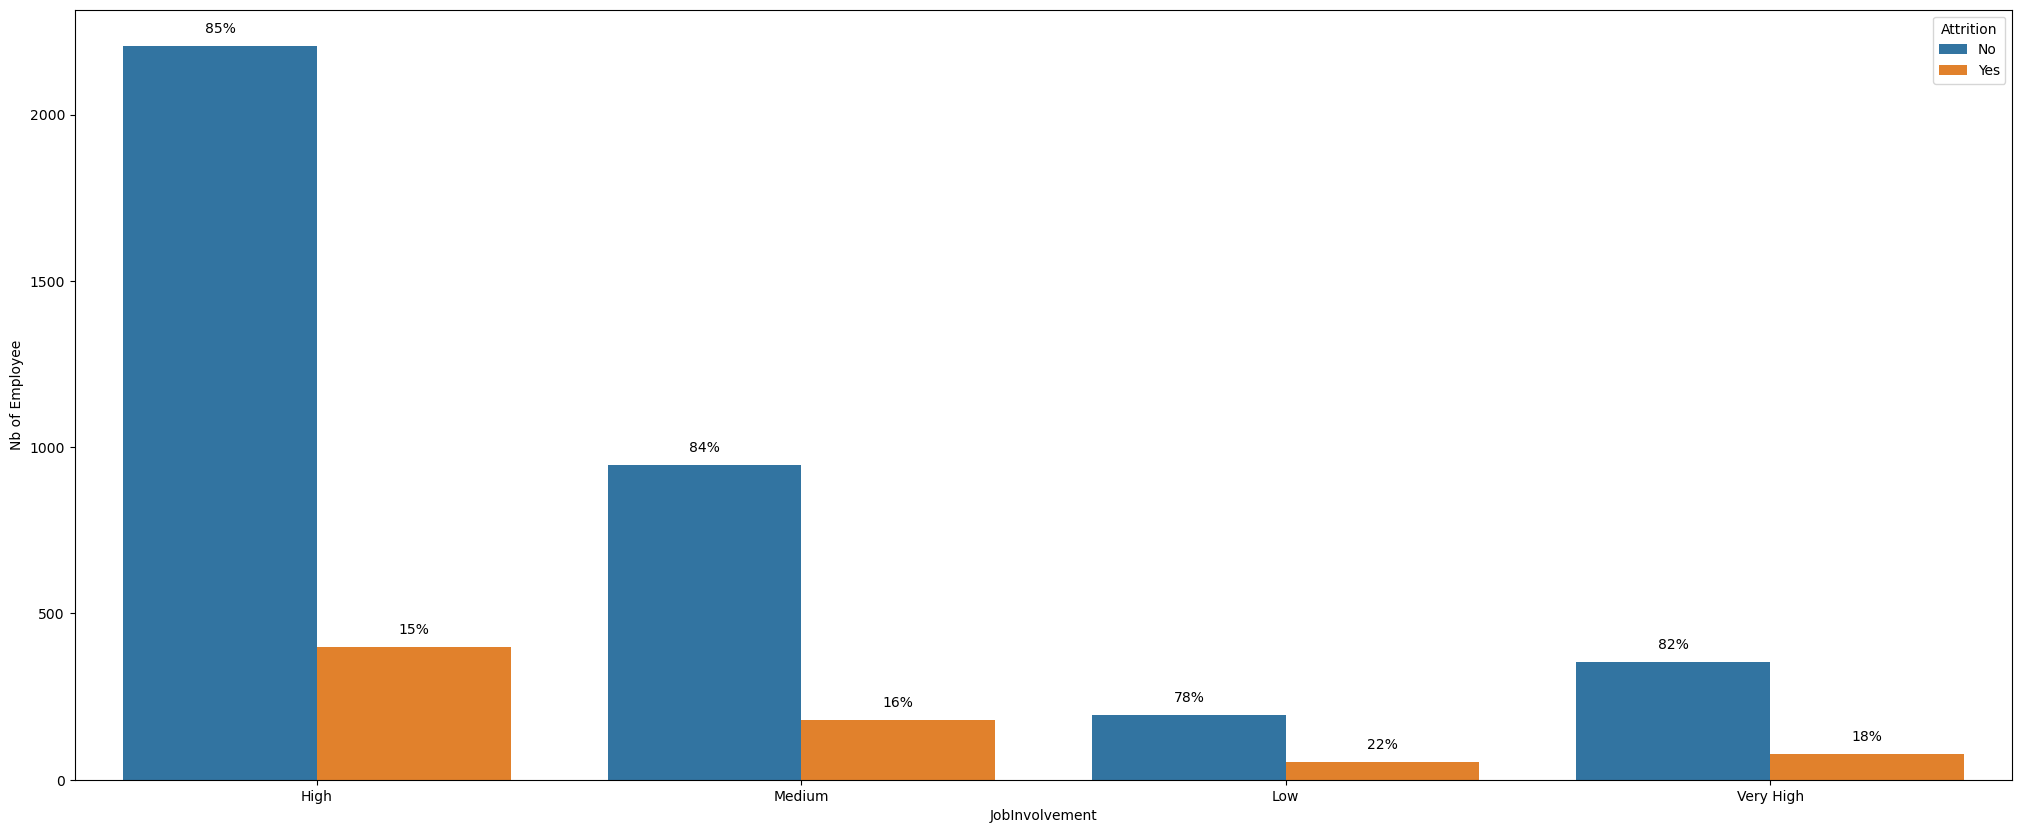

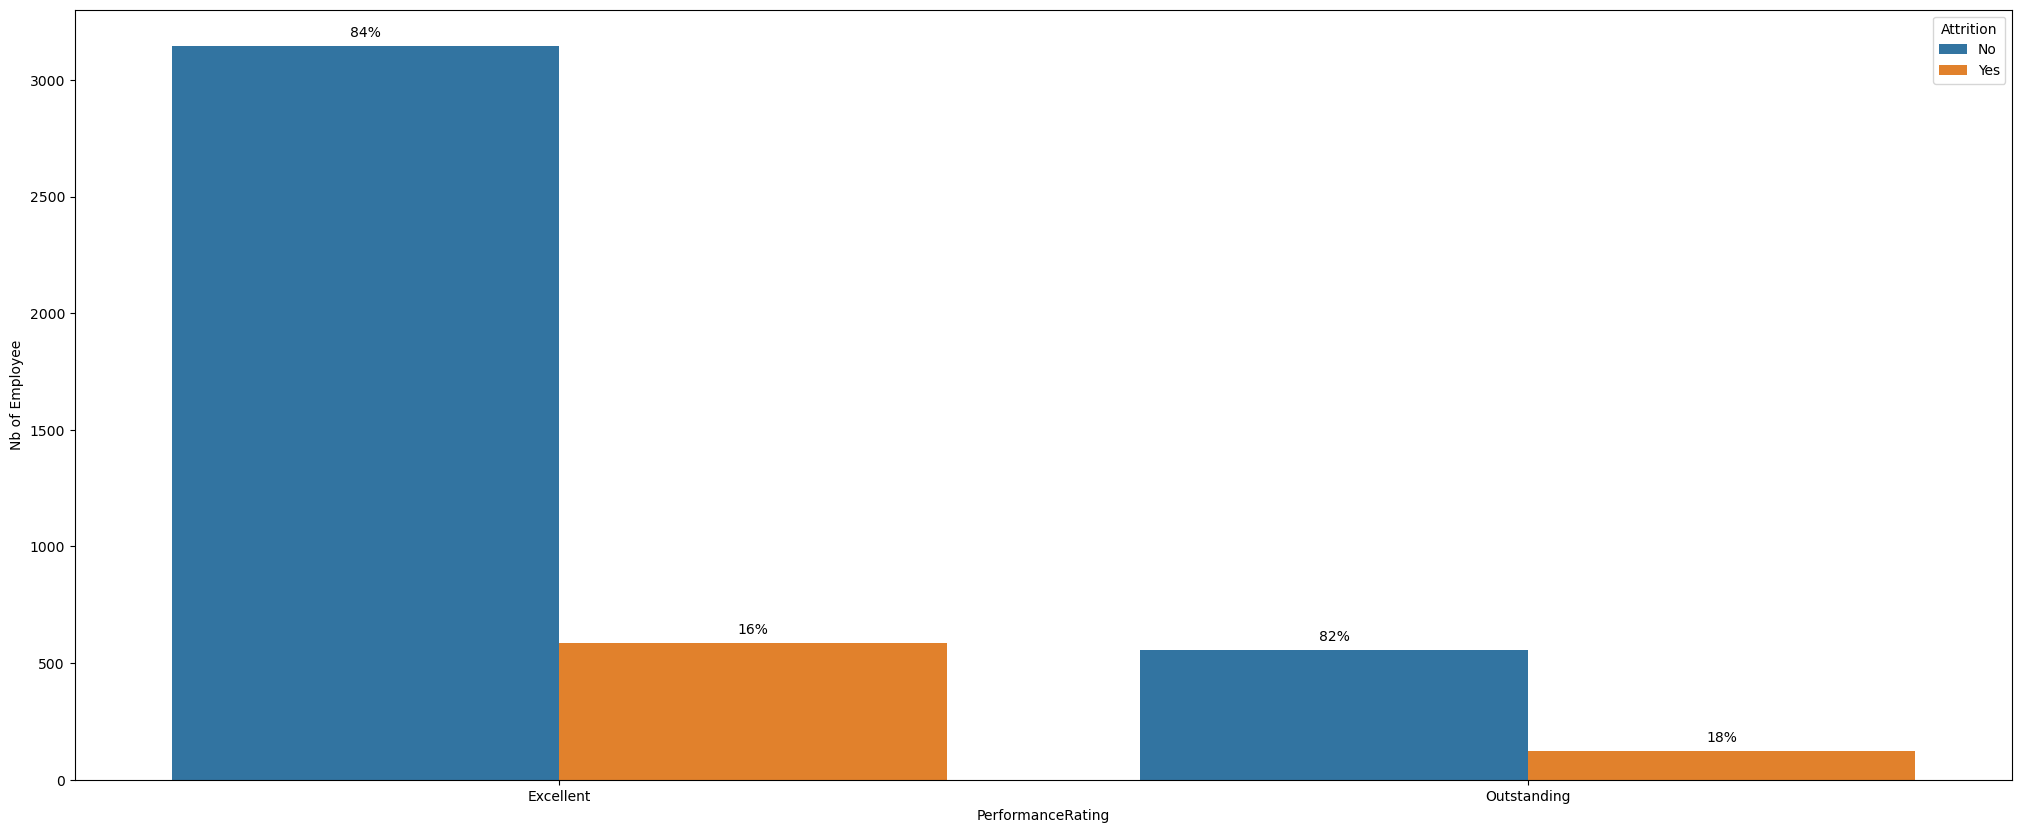

In [18]:
for name_column in general_data_copy.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        plt.figure(figsize=(25,10))
        ax = sns.countplot(x=name_column, data=general_data_copy, hue="Attrition")
        ax.set_ylabel('Nb of Employee')
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

Below you will find all the graphs with the number type variables from the dataset.

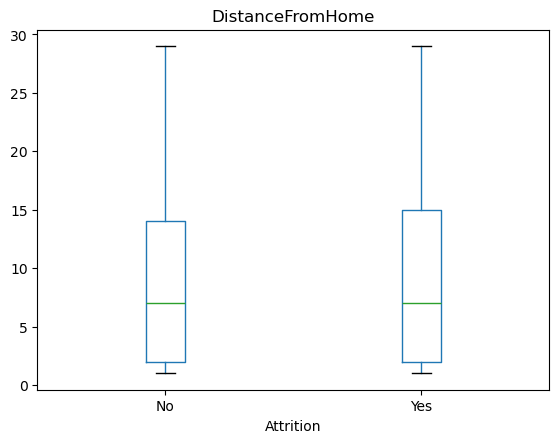

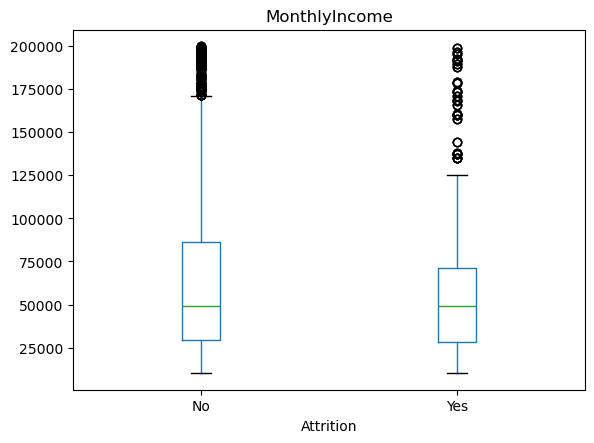

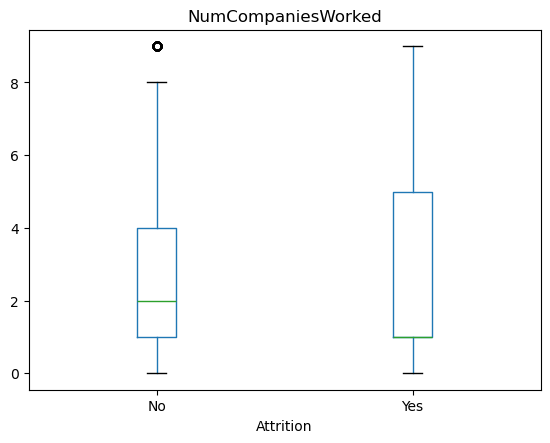

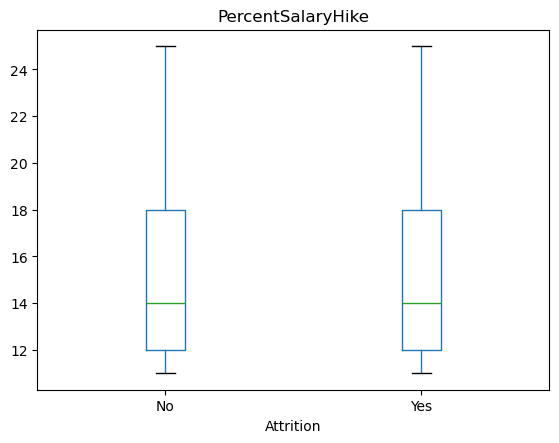

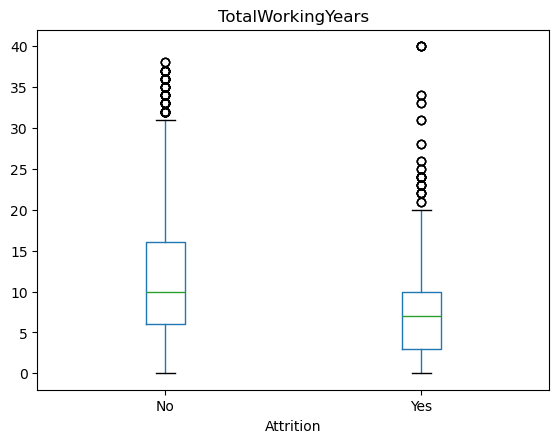

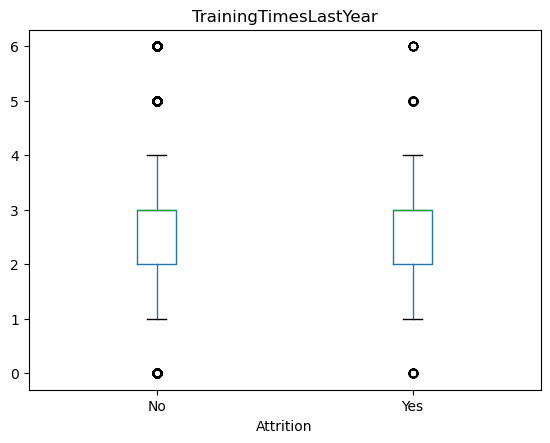

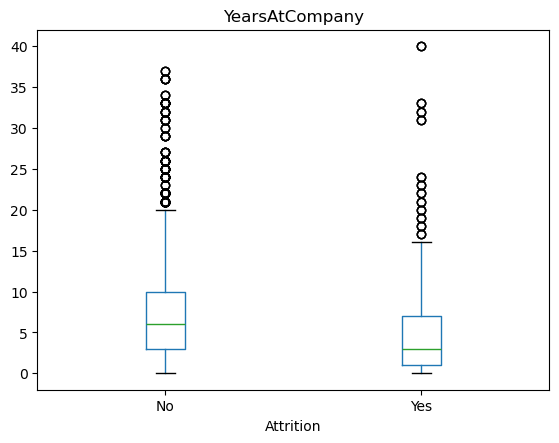

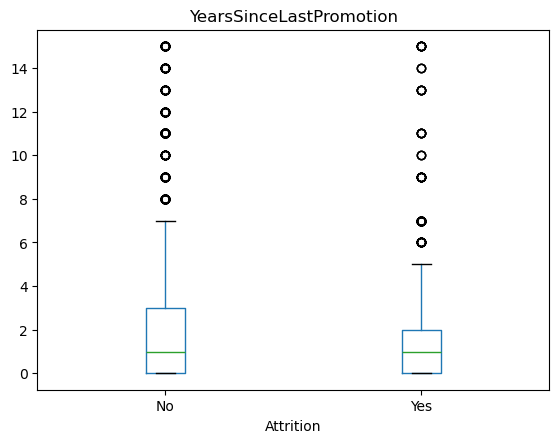

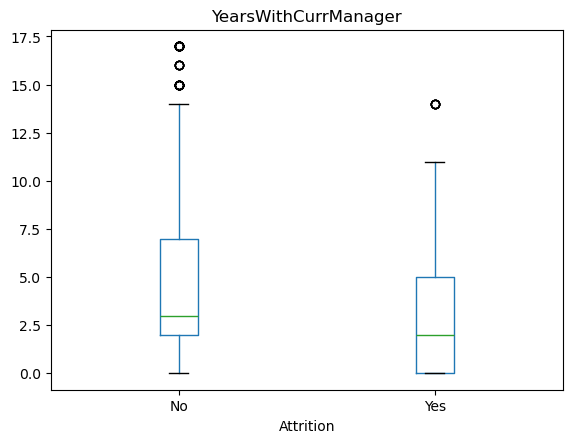

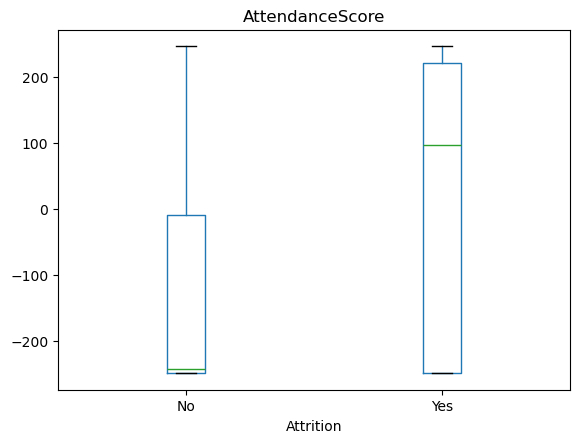

In [19]:
for name_column in general_data_copy.select_dtypes(np.number).columns:
    general_data_copy.boxplot(by ='Attrition', column = name_column, grid = False, figsize=None) 
    plt.suptitle("")

In [20]:
non_numeric_columns = general_data_copy.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index(['Attrition', 'BusinessTravel', 'Department', 'Education',
       'EducationField', 'JobLevel', 'JobRole', 'MaritalStatus',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating'],
      dtype='object')


In [21]:
from sklearn.preprocessing import LabelEncoder

# Reverse the encoding to restore original numerical values
general_data_copy['PerformanceRating'] = general_data_copy['PerformanceRating'].replace(
    {'Low': 1, 'Good': 2, 'Excellent': 3, 'Outstanding': 4}
)
general_data_copy['EnvironmentSatisfaction'] = general_data_copy['EnvironmentSatisfaction'].replace(
    {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
)
general_data_copy['JobSatisfaction'] = general_data_copy['JobSatisfaction'].replace(
    {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
)
general_data_copy['JobInvolvement'] = general_data_copy['JobInvolvement'].replace(
    {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
)
general_data_copy['WorkLifeBalance'] = general_data_copy['WorkLifeBalance'].replace(
    {'Bad': 1, 'Good': 2, 'Better': 3, 'Best': 4}
)
general_data_copy['Education'] = general_data_copy['Education'].replace(
    {'Below College': 1, 'College': 2, 'Bachelor': 3, 'Master': 4, 'Doctor': 5}
)
general_data_copy['JobLevel'] = general_data_copy['JobLevel'].replace(
    {'Apprentice': 1, 'Junior Employee': 2, 'Employee': 3, 'Manager': 4, 'Director': 5}
)
general_data_copy['Attrition'] = general_data_copy['Attrition'].replace(
    {'Yes': 1, 'No': 0}
)


label_encoder = LabelEncoder()
for col in non_numeric_columns:
    general_data_copy[col] = label_encoder.fit_transform(general_data_copy[col])




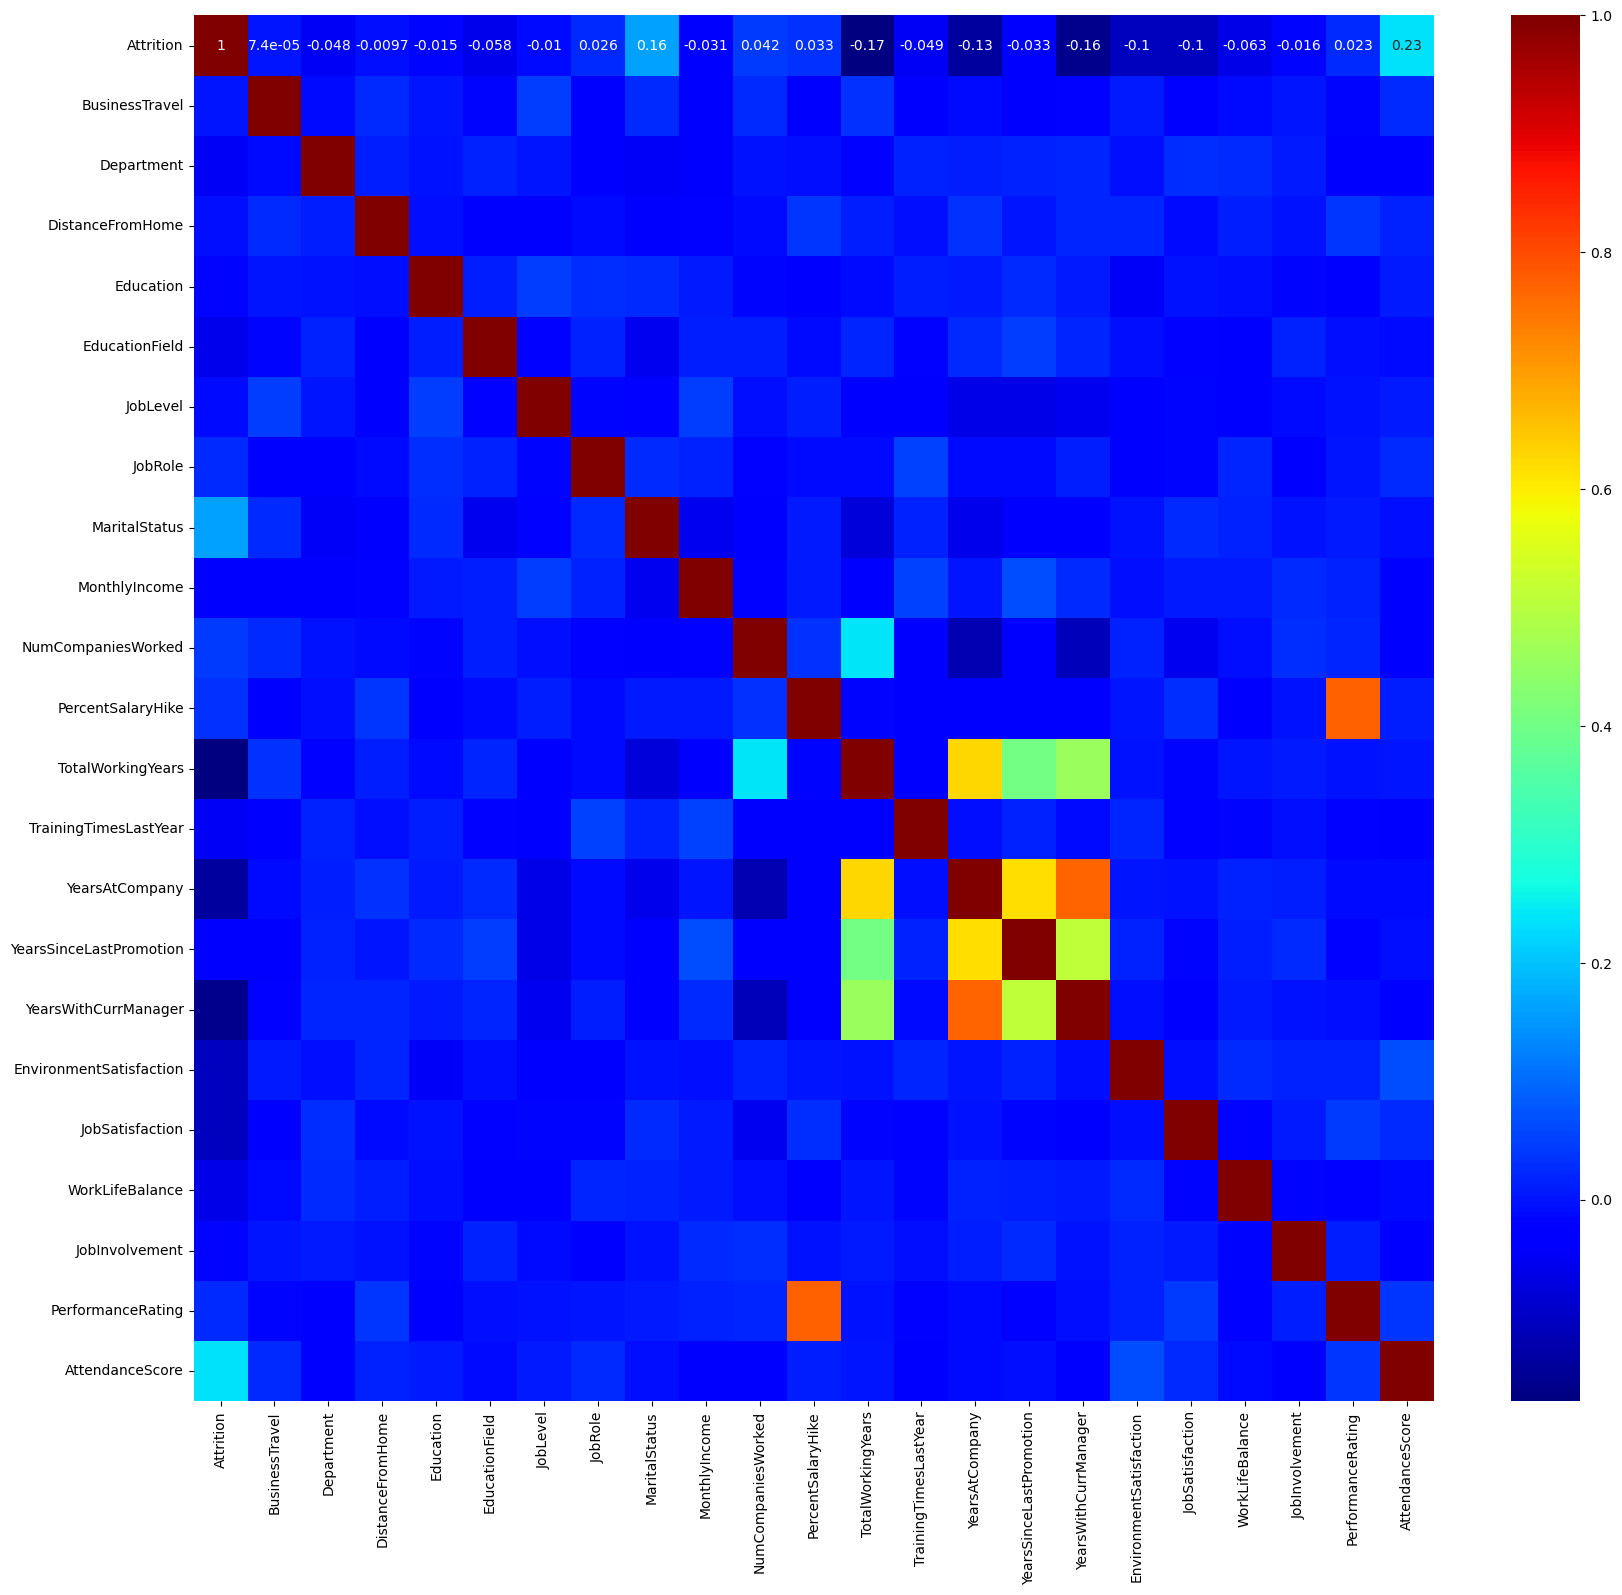

In [22]:

corr_data = general_data_copy.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(corr_data, annot=True, cmap=plt.get_cmap("jet"))

plt.show()

In [23]:
corr_data

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MaritalStatus,MonthlyIncome,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore
Attrition,1.000000,0.000074,-0.048206,-0.009730,-0.015111,-0.057940,-0.010290,0.025809,0.162070,-0.031176,...,-0.049431,-0.134392,-0.033019,-0.156199,-0.101625,-0.103068,-0.062975,-0.015588,0.023403,0.233609
BusinessTravel,0.000074,1.000000,-0.010982,0.024616,0.002755,-0.015462,0.046111,-0.027194,0.024001,-0.037597,...,-0.041888,-0.014575,-0.032591,-0.022636,0.004464,-0.032038,-0.011821,0.003121,-0.017836,0.021895
Department,-0.048206,-0.010982,1.000000,0.012134,-0.004597,0.013720,0.002923,-0.025466,-0.044619,-0.032237,...,0.012866,0.010078,0.014845,0.018016,-0.006792,0.028487,0.021840,0.006228,-0.024604,-0.032918
DistanceFromHome,-0.009730,0.024616,0.012134,1.000000,-0.008638,-0.024665,-0.037329,-0.010293,-0.027893,-0.021607,...,-0.009001,0.031684,0.002290,0.021584,0.020113,-0.011213,0.008305,-0.001837,0.036418,0.014932
Education,-0.015111,0.002755,-0.004597,-0.008638,1.000000,0.012329,0.045746,0.030155,0.024991,0.006410,...,0.010472,0.006080,0.022490,0.005358,-0.045636,-0.004612,-0.005610,-0.018279,-0.035591,0.005354
EducationField,-0.057940,-0.015462,0.013720,-0.024665,0.012329,1.000000,-0.019528,0.013106,-0.051409,0.008858,...,-0.021793,0.023120,0.048181,0.021664,-0.009988,-0.023661,-0.030210,0.013872,-0.005614,-0.014713
JobLevel,-0.010290,0.046111,0.002923,-0.037329,0.045746,-0.019528,1.000000,-0.014763,-0.022021,0.047316,...,-0.032500,-0.064219,-0.060811,-0.055251,-0.024540,-0.018596,-0.027763,-0.012630,-0.002474,0.004321
JobRole,0.025809,-0.027194,-0.025466,-0.010293,0.030155,0.013106,-0.014763,1.000000,0.022888,0.017072,...,0.051744,-0.012886,-0.014635,0.010695,-0.026068,-0.019036,0.020331,-0.029524,0.003355,0.024022
MaritalStatus,0.162070,0.024001,-0.044619,-0.027893,0.024991,-0.051409,-0.022021,0.022888,1.000000,-0.052383,...,0.012798,-0.059986,-0.030915,-0.038570,-0.004304,0.023766,0.014778,-0.004429,0.007791,-0.008719
MonthlyIncome,-0.031176,-0.037597,-0.032237,-0.021607,0.006410,0.008858,0.047316,0.017072,-0.052383,1.000000,...,0.050112,0.000995,0.065219,0.024304,-0.005747,0.004716,0.003705,0.023346,0.016093,-0.031496


## Feature Selection: Removing Non-Correlated Columns from Heatmap

In the correlation heatmap, some columns are identified as non-correlated with others. These columns are removed to prevent providing too many irrelevant parameters to the model, ensuring more reliable results and better predictive performance.

The following columns are eliminated due to their low correlation with other features:

- `BusinessTravel`
- `Department`
- `DistanceFromHome`
- `Education`
- `EducationField`
- `EmployeeID`
- `JobLevel`
- `JobRole`
- `MonthlyIncome`
- `StockOptionLevel`
- `TrainingTimesLastYear`
- `JobSatisfaction`
- `WorkLifeBalance`
- `JobInvolvement`

The function `separation_significant_parameters` is applied to the correlation matrix (`corr_data`) to separate significant and insignificant parameters.  


In [25]:
def separation_significant_parameters(frame, threshold=0.1):  
    insignificant_parameters = []
    significant_parameters = []

    for col in frame.columns:
        # Get maximum absolute correlation excluding self-correlation (diagonal = 1)
        max_correlation = frame[col].drop(col).abs().max()
        
        if max_correlation < threshold:
            insignificant_parameters.append(col)
        else:
            significant_parameters.append(col)

    return significant_parameters, insignificant_parameters

def retain_terminal(frame):
    for i in frame.keys():
        for a in range(len(frame[i])):
            if frame[i][a] > 0.1 or frame[i][a] < -0.1:
                frame[i][a] = frame[i][a]
            else:
                frame[i][a] = 0
    return frame

In [26]:


significant_parameter, insignificant_parameter = separation_significant_parameters(corr_data)


C:\Users\pc\AppData\Local\Temp\ipykernel_17288\3652800369.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if frame[i][a] > 0.1 or frame[i][a] < -0.1:
C:\Users\pc\AppData\Local\Temp\ipykernel_17288\3652800369.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frame[i][a] = frame[i][a]
C:\Users\pc\AppData\Local\Temp\ipykernel_17288\3652800369.py:20: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  frame[i][a] = frame[i][a]
C:

<Axes: >

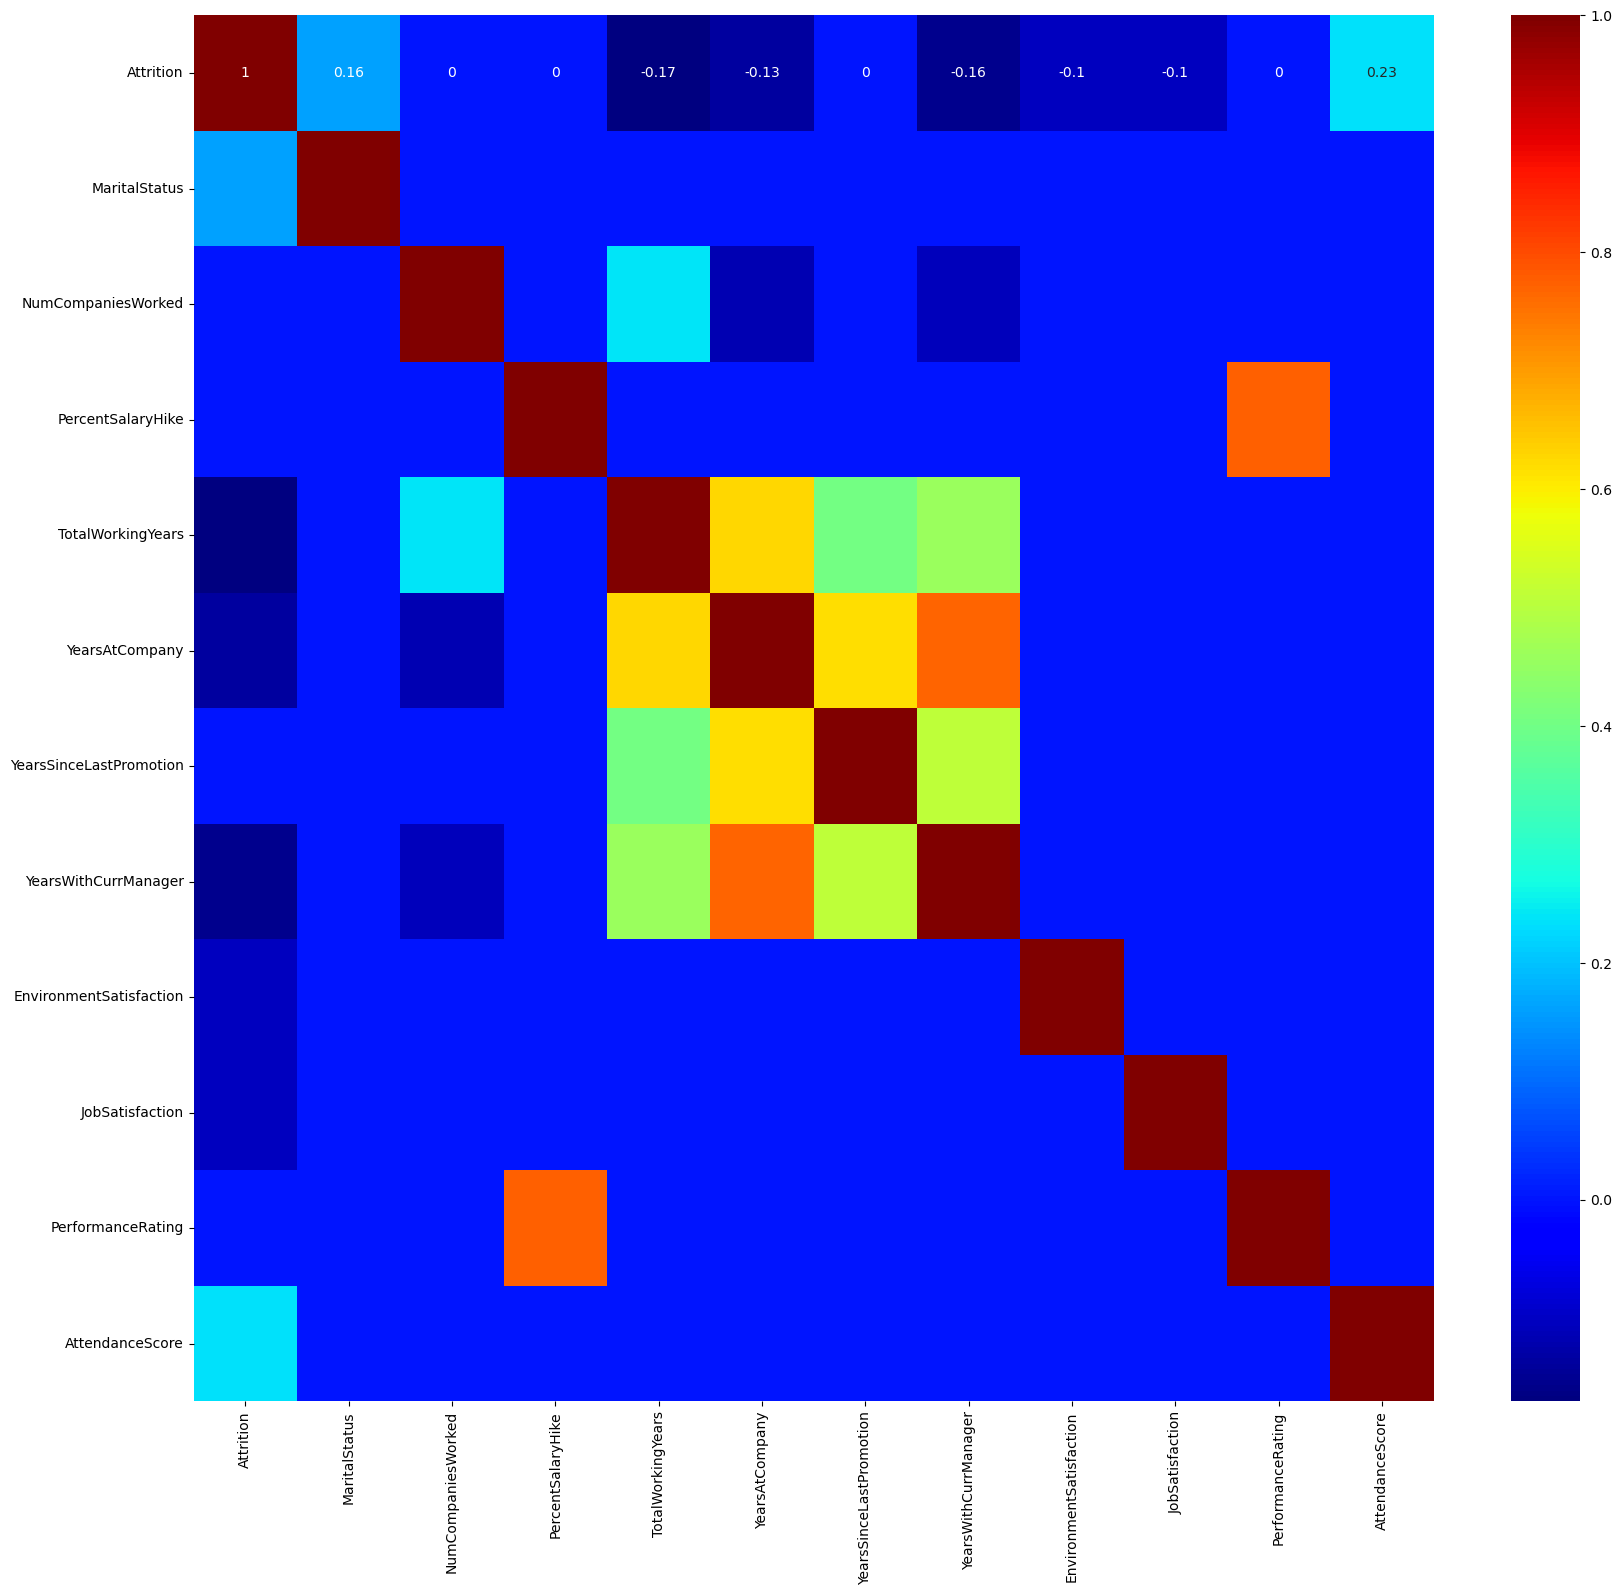

In [ ]:
corr_tmp = general_data_copy[significant_parameter].corr()
corr_tmp = retain_terminal(corr_tmp)

plt.figure(figsize=(20,18))
sns.heatmap(corr_tmp, annot = True, cmap=plt.get_cmap("jet"))


In [27]:
general_data_copy.head()

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MaritalStatus,MonthlyIncome,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore
0,0,2,2,6,1,1,0,0,1,131160,...,6,1,0,0,2,3,1,2,0,-249
1,1,1,1,10,0,1,0,6,2,41890,...,3,5,1,4,2,1,3,1,1,-165
2,0,1,1,17,3,4,3,7,1,193280,...,2,5,0,3,1,1,0,2,0,-249
3,0,0,1,2,4,1,2,1,1,83210,...,5,8,7,5,3,3,2,1,0,-249
4,0,2,1,10,0,3,0,7,2,23420,...,2,6,0,4,3,0,2,2,0,-19


In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

X = general_data_copy.iloc[:, [1] + list(range(2, general_data_copy.shape[1]))]
y = general_data_copy.iloc[:, 0] 

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X_train.head()

,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AttendanceScore
3465,2,2,1,3,1,0,5,1,52570,1.0,...,2,10,0,8,1,2,2,3,0,-81
3485,0,2,1,0,2,1,5,1,26960,3.0,...,3,0,0,0,2,3,2,2,1,-249
3052,2,0,10,1,0,0,2,2,53730,1.0,...,2,1,0,0,2,1,2,2,0,-249
2012,1,1,7,2,1,1,3,0,29760,1.0,...,3,1,0,0,0,1,2,2,0,-249
426,2,1,1,3,3,1,6,0,192320,2.0,...,3,1,0,0,0,1,1,2,0,-249


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit


Logistic Regression:
Accuracy: 0.8515

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       740
           1       0.63      0.18      0.28       142

    accuracy                           0.85       882
   macro avg       0.75      0.58      0.60       882
weighted avg       0.83      0.85      0.82       882


Perceptron:
Accuracy: 0.8390

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       740
           1       0.00      0.00      0.00       142

    accuracy                           0.84       882
   macro avg       0.42      0.50      0.46       882
weighted avg       0.70      0.84      0.77       882


SVC:
Accuracy: 0.8390

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       740
           1       0.00      0.00      0.00       142

    accuracy      

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Random Forest:
Accuracy: 0.9921

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       740
           1       1.00      0.95      0.97       142

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.99       882
weighted avg       0.99      0.99      0.99       882



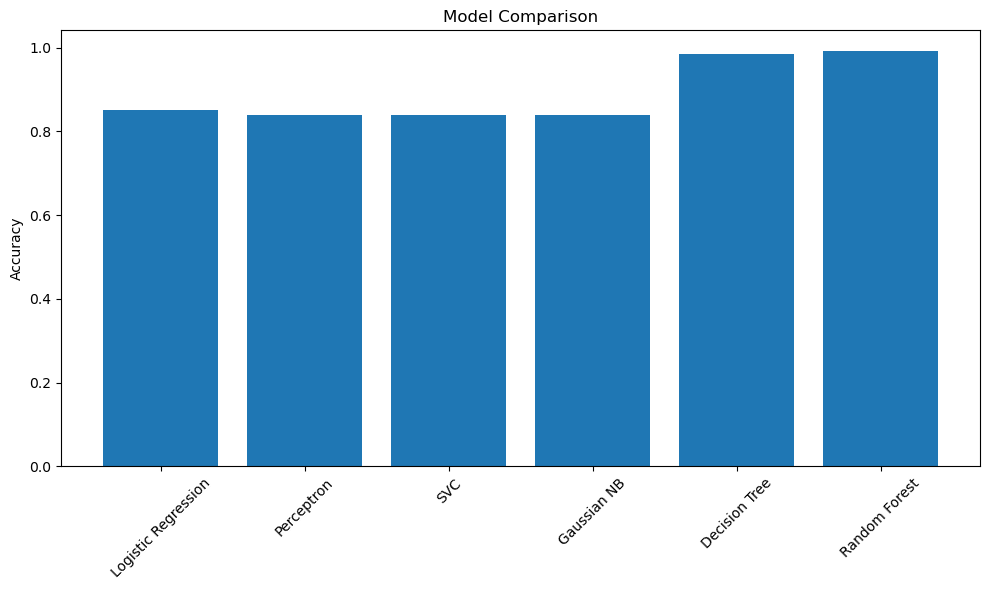

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Create a dictionary of models
models = {
    'Logistic Regression': LogisticRegression(),
    'Perceptron': Perceptron(),
    'SVC': SVC(),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f'\n{name}:')
    print(f'Accuracy: {accuracy:.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.tight_layout()
plt.show()


Training Logistic Regression...

Training SVC...

Training Decision Tree...

Training Random Forest...


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



Training Gaussian NB...

Training Perceptron...

Logistic Regression:
Best Score: 0.8614
Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

SVC:
Best Score: 0.8912
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Decision Tree:
Best Score: 0.8940
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}

Random Forest:
Best Score: 0.9461
Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}

Gaussian NB:
Best Score: 0.8475
Best Parameters: {'var_smoothing': 1e-08}

Perceptron:
Best Score: 0.8387
Best Parameters: {'alpha': 0.0001, 'max_iter': 1000, 'penalty': None}


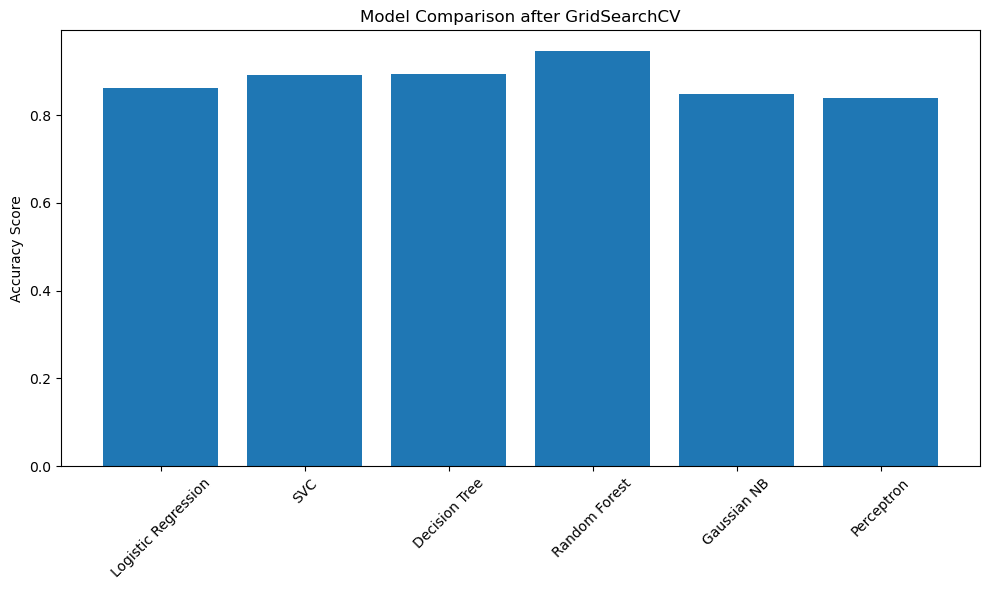


Best Overall Model: Random Forest
Best Overall Score: 0.9461

Test Set Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       740
           1       1.00      0.96      0.98       142

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.99       882
weighted avg       0.99      0.99      0.99       882



In [30]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Dictionary of models and their hyperparameters
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'criterion': ['gini', 'entropy']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5],
            'max_features': ['auto', 'sqrt']
        }
    },
    'Gaussian NB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'Perceptron': {
        'model': Perceptron(),
        'params': {
            'penalty': [None, 'l1', 'l2'],
            'alpha': [0.0001, 0.001, 0.01],
            'max_iter': [1000]
        }
    }
}

# Perform GridSearch for each model
best_scores = {}
best_models = {}

for model_name, mp in model_params.items():
    print(f'\nTraining {model_name}...')
    
    # Create GridSearch object
    grid_search = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=2,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store best score and parameters
    best_scores[model_name] = {
        'Best Score': grid_search.best_score_,
        'Best Parameters': grid_search.best_params_
    }
    
    # Store best model
    best_models[model_name] = grid_search.best_estimator_

# Print results
for model_name, scores in best_scores.items():
    print(f'\n{model_name}:')
    print(f"Best Score: {scores['Best Score']:.4f}")
    print(f"Best Parameters: {scores['Best Parameters']}")

# Visualize results
plt.figure(figsize=(10, 6))
scores = [score['Best Score'] for score in best_scores.values()]
plt.bar(best_scores.keys(), scores)
plt.xticks(rotation=45)
plt.ylabel('Accuracy Score')
plt.title('Model Comparison after GridSearchCV')
plt.tight_layout()
plt.show()

# Find the best overall model
best_model_name = max(best_scores.items(), key=lambda x: x[1]['Best Score'])[0]
best_model = best_models[best_model_name]

print(f"\nBest Overall Model: {best_model_name}")
print(f"Best Overall Score: {best_scores[best_model_name]['Best Score']:.4f}")

# Evaluate best model on test set
y_pred = best_model.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))

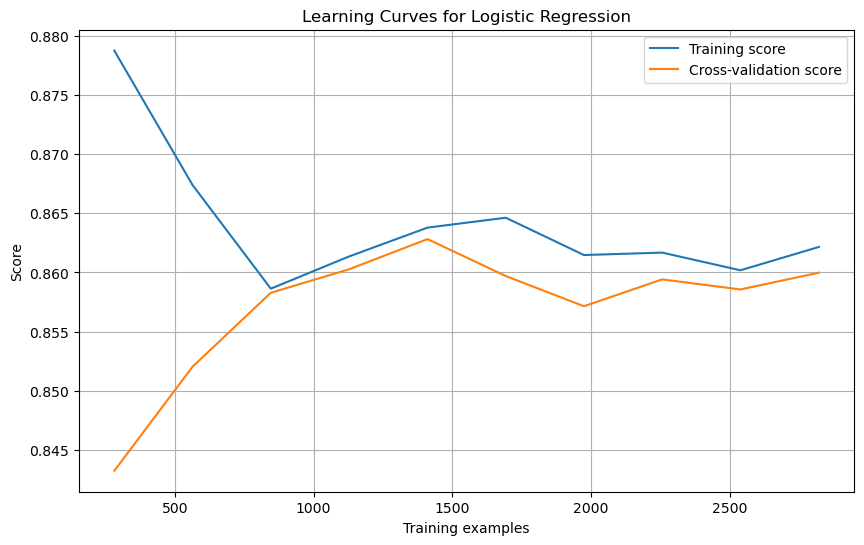

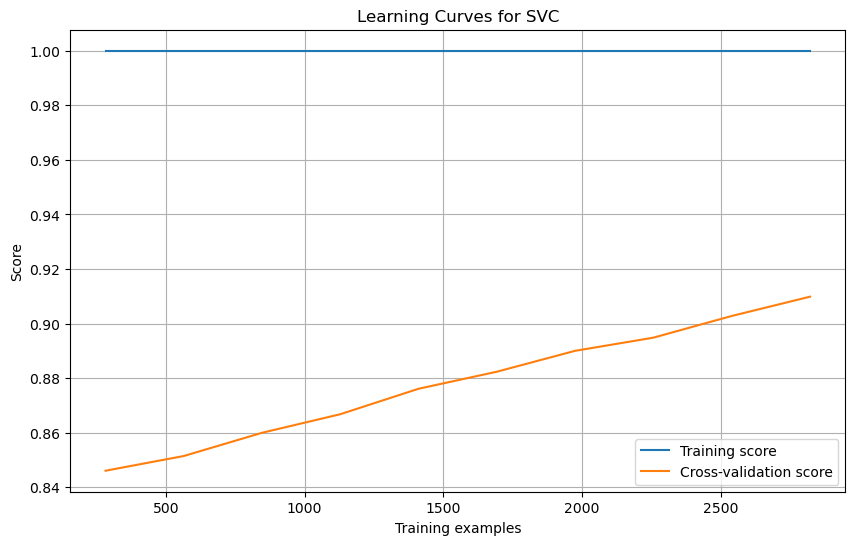

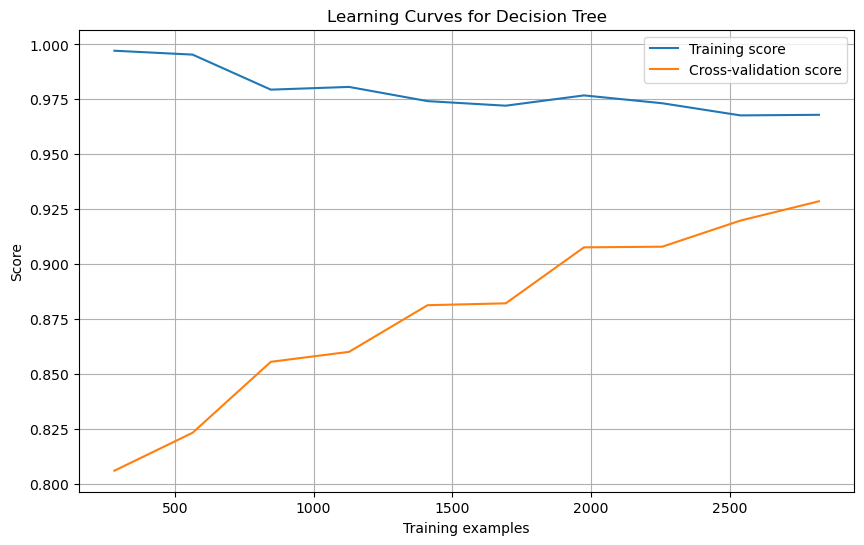

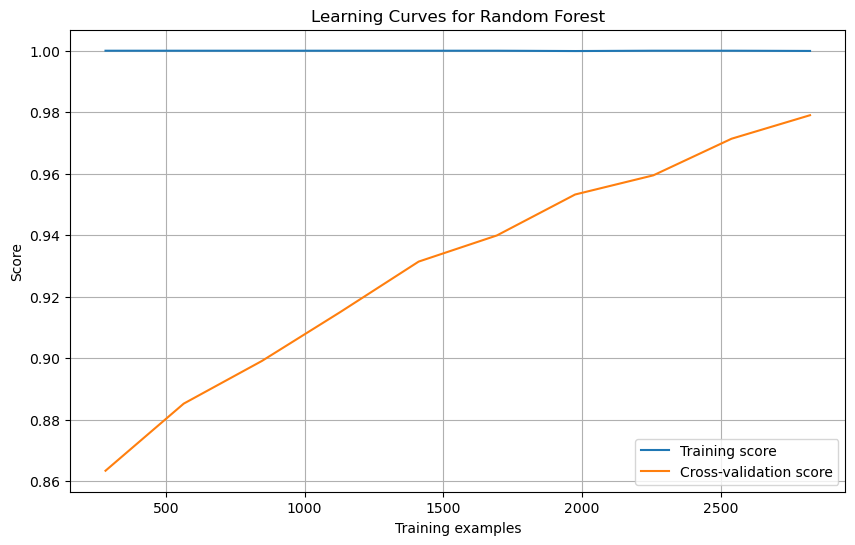

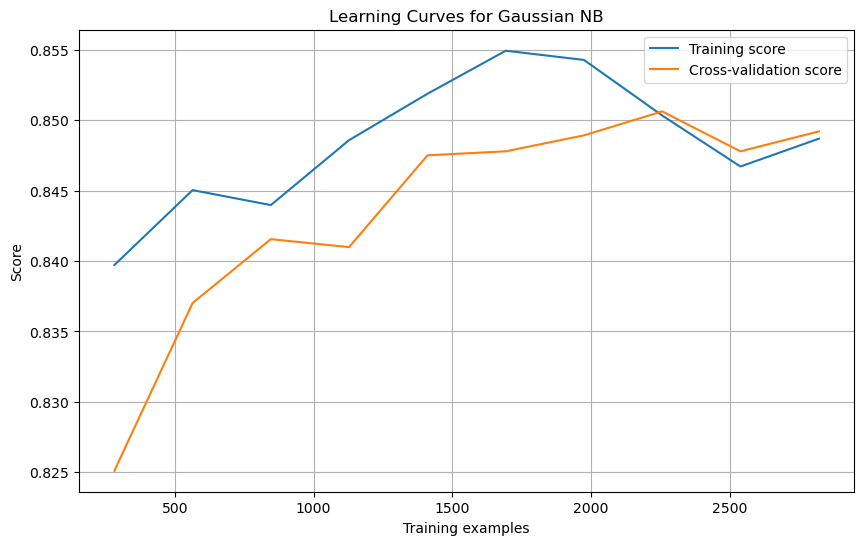

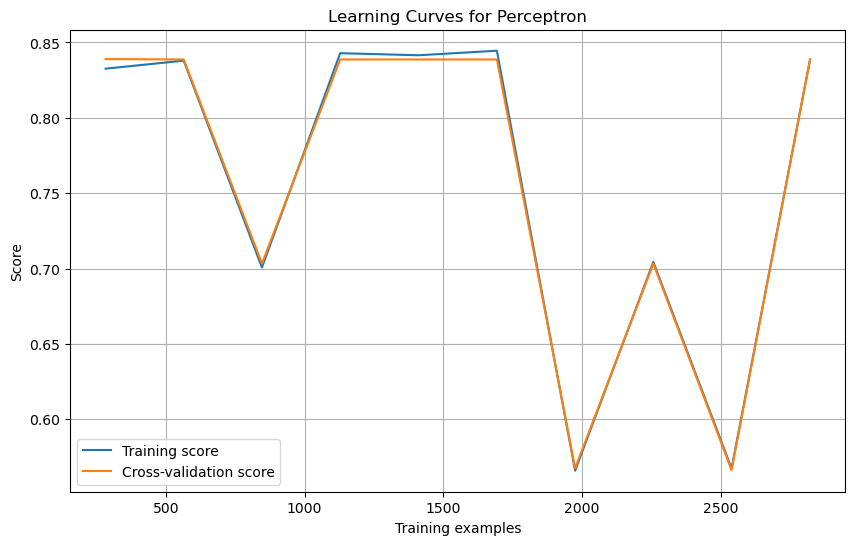

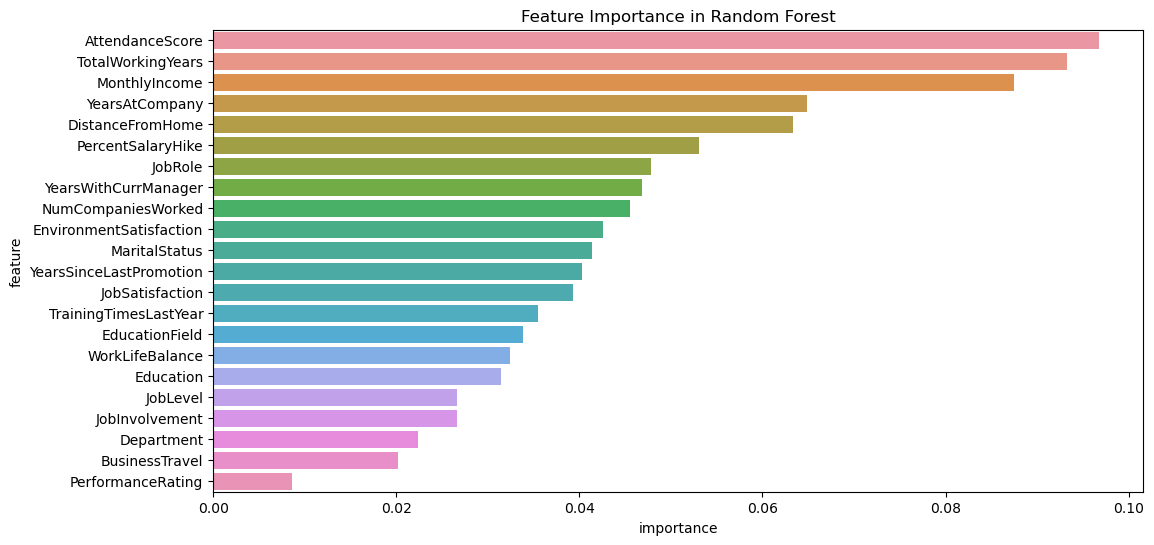

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1200x600 with 0 Axes>

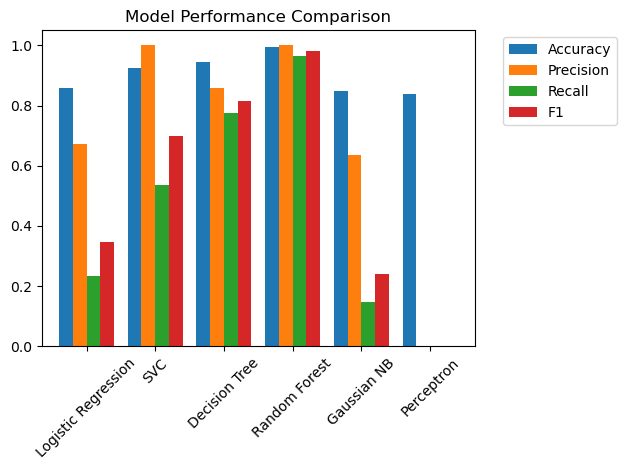

Some models don't support probability predictions


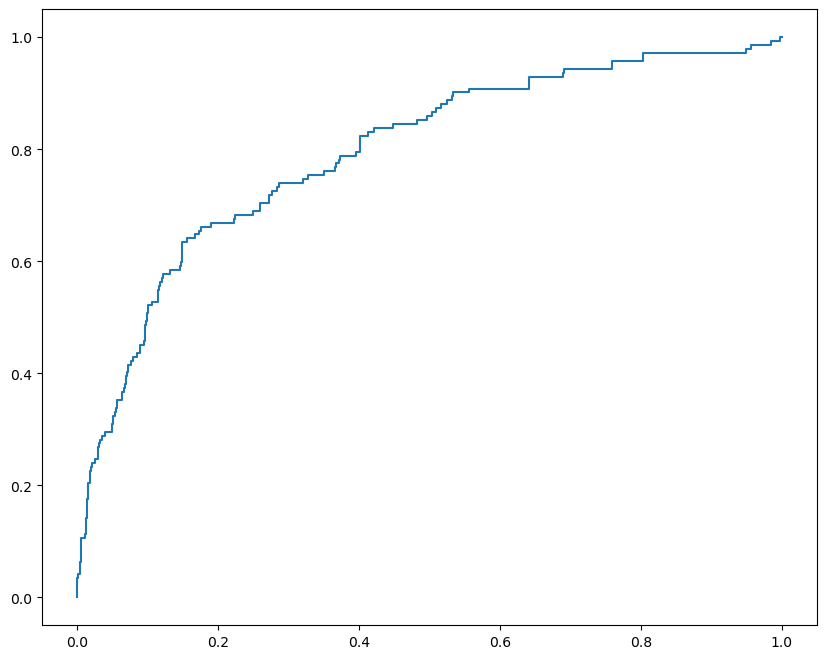

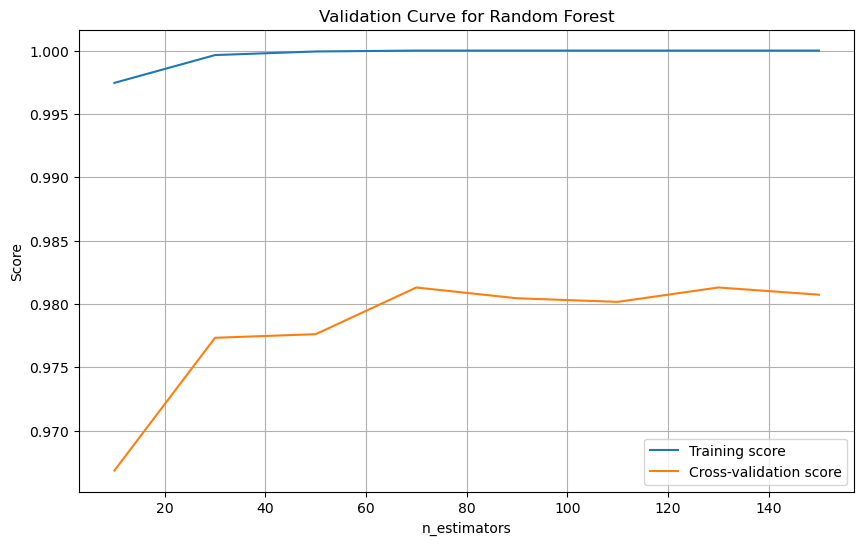

In [31]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# 1. Learning Curves for Best Models
def plot_learning_curves(model, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curves for {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curves for each best model
for name, model in best_models.items():
    plot_learning_curves(model, X_train, y_train, name)

# 2. Hyperparameter Heat Maps (for models with 2 main hyperparameters)
def plot_param_heatmap(grid_search, param1, param2, model_name):
    scores = grid_search.cv_results_['mean_test_score']
    params = grid_search.cv_results_['params']
    
    # Extract unique values for both parameters
    p1_values = sorted(set(p[param1] for p in params))
    p2_values = sorted(set(p[param2] for p in params))
    
    # Create score matrix
    score_matrix = np.zeros((len(p1_values), len(p2_values)))
    for i, p1 in enumerate(p1_values):
        for j, p2 in enumerate(p2_values):
            for idx, param in enumerate(params):
                if param[param1] == p1 and param[param2] == p2:
                    score_matrix[i, j] = scores[idx]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(score_matrix, annot=True, fmt='.3f', 
                xticklabels=p2_values, yticklabels=p1_values)
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.title(f'Hyperparameter Heatmap for {model_name}')
    plt.show()

# 3. Parameter Importance Plot (Random Forest)
if 'Random Forest' in best_models:
    rf_model = best_models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance in Random Forest')
    plt.show()

# 4. Model Performance Comparison
def plot_model_metrics():
    metrics = {}
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        metrics[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred)
        }
    
    metrics_df = pd.DataFrame(metrics).T
    
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar', width=0.8)
    plt.title('Model Performance Comparison')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

plot_model_metrics()

# 5. ROC Curves
def plot_roc_curves():
    plt.figure(figsize=(10, 8))
    for name, model in best_models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.show()

# Make sure models have predict_proba method before calling
try:
    plot_roc_curves()
except:
    print("Some models don't support probability predictions")

# 6. Validation Curves for specific parameters
def plot_validation_curve(model, param_name, param_range, model_name):
    train_scores, val_scores = validation_curve(
        model, X_train, y_train,
        param_name=param_name,
        param_range=param_range,
        cv=5, scoring='accuracy'
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(param_range, np.mean(val_scores, axis=1), label='Cross-validation score')
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.title(f'Validation Curve for {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example for Random Forest n_estimators
if 'Random Forest' in best_models:
    plot_validation_curve(
        RandomForestClassifier(),
        "n_estimators",
        [10, 30, 50, 70, 90, 110, 130, 150],
        "Random Forest"
    )